## Описание проекта
Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
<br>
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала <b>не менее 6000 килограммов молока в год</b>, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!
Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
- Первая будет прогнозировать возможный удой коровы (целевой признак `Удой`);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак `Вкус молока`).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.


### Описание данных

1. Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент. Описание данных:
    - `id` — уникальный идентификатор коровы.
    - `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
    - `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
    - `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
    - `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
    - `Порода` — порода коровы.
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    - `порода папы_быка` — порода папы коровы.
    - `Жирность,%` — содержание жиров в молоке (в процентах).
    - `Белок,%` — содержание белков в молоке (в процентах).
    - `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
    - `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

    Признаки в датасете `ferma_main.csv` можно разделить на группы.
    - Характеристики коровы: `id`, `Порода`, `порода папы_быка`, `Возраст`.
    - Характеристики корма: `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г`, `СПО (Сахаро-протеиновое соотношение)`.
    - Характеристика пастбища: `Тип пастбища`.
    - Характеристики молока: `Удой, кг`, `Жирность,%`, `Белок,%`, `Вкус молока`.

<br>

2. Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера. Описание данных:
    - `id` — уникальный идентификатор коровы.
    - `Имя Папы` — имя папы коровы.

<br>

3. Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
    - `Порода` — порода коровы.
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    - `порода папы_быка` — порода папы коровы.
    - `Имя_папы` — имя папы коровы.
    - `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
    - `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
    - `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

<br>
<br>

Данные в файлах `ferma_main.csv` и `cow_buy.csv` похожи, но у датасета `cow_buy.csv` несколько особенностей.
- Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
- Параметры корма `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)` отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
- Кроме того, отсутствуют признаки `Удой, кг` и `Вкус молока`. Это целевые признаки, именно их предстоит предсказать!


In [159]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import phik
import warnings

# Импорт для разбиения данных на выборки
from sklearn.model_selection import train_test_split

# Импорт для кодирования и масштабирования
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)

# Импорт для обучения моделей
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)

# Импорт метрик
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)


warnings.filterwarnings('ignore')
# pd.options.display.float_format = '{:,.1f}'.format

## Загрузка данных

In [160]:
try:
    cow_buy = pd.read_csv('farm_market/data/cow_buy.csv', sep=';', decimal=',')
    ferma_dad = pd.read_csv('farm_market/data/ferma_dad.csv', sep=';', decimal=',')
    ferma_main = pd.read_csv('farm_market/data/ferma_main.csv', sep=';', decimal=',')
except:
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')

In [161]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [162]:
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [163]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Переименуем столбцы перед работой с данными

In [164]:
cow_buy = cow_buy.rename(columns={'Порода': 'breed',
                                  'Тип пастбища': 'pasture',
                                  'порода папы_быка': 'father_breed',
                                  'Имя_папы': 'father_name',
                                  'Текущая_жирность,%': 'current_fat_content',
                                  'Текущий_уровень_белок,%': 'current_protein',
                                  'Возраст': 'age'})

ferma_dad = ferma_dad.rename(columns={'id': 'id',
                                      'Имя Папы': 'father_name'})

ferma_main = ferma_main.rename(columns={'id': 'id',
                                        'Удой, кг': 'milk_yield',
                                        'ЭКЕ (Энергетическая кормовая единица)': 'feed_unit',
                                        'Сырой протеин, г': 'raw_protein',
                                        'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
                                        'Порода': 'breed',
                                        'Тип пастбища': 'pasture',
                                        'порода папы_быка': 'father_breed',
                                        'Жирность,%': 'fat_content',
                                        'Белок,%': 'protein',
                                        'Вкус молока': 'milk_taste',
                                        'Возраст': 'age'})

# Проверим, корректно ли мы переименовали все столбцы
print(cow_buy.columns, end='\n\n')
print(ferma_dad.columns, end='\n\n')
print(ferma_main.columns, end='\n\n')

Index(['breed', 'pasture', 'father_breed', 'father_name',
       'current_fat_content', 'current_protein', 'age'],
      dtype='object')

Index(['id', 'father_name'], dtype='object')

Index(['id', 'milk_yield', 'feed_unit', 'raw_protein', 'sugar_protein_ratio',
       'breed', 'pasture', 'father_breed', 'fat_content', 'protein',
       'milk_taste', 'age'],
      dtype='object')



Мы переименовали столбцы следующим образом:

В датасете `cow_buy`:
- `Порода` мы переименовали в `breed`
- `Тип пастбища` мы переименовали в `pasture`
- `порода папы_быка` мы переименовали в `father_breed`
- `Имя_папы` мы переименовали в `father_name`
- `Текущая_жирность,%` мы переименовали в `current_fat_content`
- `Текущий_уровень_белок,%` мы переименовали в `current_protein`
- `Возраст` мы переименовали в `age`

В датасете `ferma_dad`:
- `id` мы переименовали в `id`
- `Имя Папы` мы переименовали в `father_name`

В датасете `ferma_main`:
- `id` мы переименовали в `id`
- `Удой, кг` мы переименовали в `milk_yield`
- `ЭКЕ (Энергетическая кормовая единица)` мы переименовали в `feed_unit`
- `Сырой протеин, г` мы переименовали в `raw_protein`
- `СПО (Сахаро-протеиновое соотношение)` мы переименовали в `sugar_protein_ratio`
- `Порода` мы переименовали в `breed`
- `Тип пастбища` мы переименовали в `pasture`
- `порода папы_быка` мы переименовали в `father_breed`
- `Жирность,%` мы переименовали в `fat_content`
- `Белок,%` мы переименовали в `protein`
- `Вкус молока` мы переименовали в `milk_taste`
- `Возраст` мы переименовали в `age`

Выведем информацию по каждому датафрейму

In [165]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   breed                20 non-null     object 
 1   pasture              20 non-null     object 
 2   father_breed         20 non-null     object 
 3   father_name          20 non-null     object 
 4   current_fat_content  20 non-null     float64
 5   current_protein      20 non-null     float64
 6   age                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [166]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           629 non-null    int64 
 1   father_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [167]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   milk_yield           634 non-null    int64  
 2   feed_unit            634 non-null    float64
 3   raw_protein          634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   pasture              634 non-null    object 
 7   father_breed         634 non-null    object 
 8   fat_content          634 non-null    float64
 9   protein              634 non-null    float64
 10  milk_taste           634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


При первом ознакомлении, мы можем наблюдать, что у нас отсутствуют пропуски столбцах, а так же, что данные приведены к корректному типу, однако позже стоит рассмотреть это детальнее. Так же стоит отметить, что в датафреймах `ferma_dad` и `ferma_main` разное количество строк

### Вывод:

Мы импортировали данные в 3 разных датафрейма, привели имена столбцов к единому стилю, и кратко просмотрели информацию о каждом из них

##  Предобработка данных

Проверим данные на наличие пропусков и дубликатов. Узнаем, корректны ли типы данных у каждого признака. При необходимости устраним все проблемы с данными

In [168]:
# Проверим на наличие пропусков
print(f'cow_buy:\n{cow_buy.isna().sum()}\n')
print(f'ferma_dad:\n{ferma_dad.isna().sum()}\n')
print(f'ferma_main:\n{ferma_main.isna().sum()}\n')

cow_buy:
breed                  0
pasture                0
father_breed           0
father_name            0
current_fat_content    0
current_protein        0
age                    0
dtype: int64

ferma_dad:
id             0
father_name    0
dtype: int64

ferma_main:
id                     0
milk_yield             0
feed_unit              0
raw_protein            0
sugar_protein_ratio    0
breed                  0
pasture                0
father_breed           0
fat_content            0
protein                0
milk_taste             0
age                    0
dtype: int64



In [169]:
# Проверка на наличие дубликатов
# print(f'cow_buy: {cow_buy.duplicated().sum()}')
print(f'ferma_dad: {ferma_dad.duplicated().sum()}')
print(f'ferma_main: {ferma_main.duplicated().sum()}')

ferma_dad: 0
ferma_main: 5


### Предобработка категориальных столбцов

Устраним неявные дубликаты в категориальных столбцах и приведем их к единому виду

In [170]:
# Удаляем явные дубликаты
# cow_buy = cow_buy.drop_duplicates()
ferma_main = ferma_main.drop_duplicates()

# Проверяем, остались ли у нас еще явные дубликаты
# print(f'cow_buy: {cow_buy.duplicated().sum()}')
print(f'ferma_dad: {ferma_dad.duplicated().sum()}')
print(f'ferma_main: {ferma_main.duplicated().sum()}')

ferma_dad: 0
ferma_main: 0


Теперь детальнее рассмотрим к каким типам данных принадлежат столбцы, а так же в каких из них могут быть неявные дубликаты

In [171]:
cow_buy.head()

,breed,pasture,father_breed,father_name,current_fat_content,current_protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [172]:
ferma_dad.head()

,id,father_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [173]:
ferma_main.head()

,id,milk_yield,feed_unit,raw_protein,sugar_protein_ratio,breed,pasture,father_breed,fat_content,protein,milk_taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Нам нужно преобразовать следующие столбцы:

<br>

В датафрейме `cow_buy`
- `current_fat_content` к типу `float`
- `current_protein` к типу `float`
- `age` к типу `bool`, где 1 — более 2-х лет, а 0 — менее 2 лет

<br>

В датафрейме `ferma_main`
- `feed_unit` к типу `float`
- `sugar_protein_ratio` к типу `float`
- `fat_content` к типу `float`
- `protein` к типу `float`
- `milk_taste` к типу `bool`, где 1 — вкусно, а 2 — не вкусно
- `age` к типу `bool`, где 1 — более 2-х лет, а 0 — менее 2 лет

Посмотрим на то, есть ли у нас неявные дубликаты в категориальных столбцах
<br>
Для этого сначала создадим список со столбцами, которые содержат категориальные значения. Мы сможем использовать эти данные в дальнейшем

In [174]:
# Создаем списки
cow_buy_num_col_name = ['current_fat_content', 'current_protein']
cow_buy_cat_col_name = ['breed', 'pasture', 'father_breed', 'father_name', 'age']

ferma_main_num_col_name = ['milk_yield', 'feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein', ]
ferma_main_cat_col_name = ['breed', 'pasture', 'father_breed', 'milk_taste', 'age']

In [175]:
for name in cow_buy_cat_col_name:
    print(name, ':', cow_buy[name].unique())

print()

for name in ferma_main_cat_col_name:
    print(name, ':', ferma_main[name].unique())

breed : ['Вис Бик Айдиал' 'РефлешнСоверинг']
pasture : ['холмистое' 'равнинное']
father_breed : ['Айдиал' 'Соверин']
father_name : ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
age : ['более_2_лет' 'менее_2_лет']

breed : ['Вис Бик Айдиал' 'РефлешнСоверинг']
pasture : ['Равнинное' 'Равнинные' 'Холмистое']
father_breed : ['Айдиал' 'Соверин' 'Айдиалл']
milk_taste : ['вкусно' 'не вкусно']
age : ['более_2_лет' 'менее_2_лет']


У нас есть неочевидные дубликаты в столбце `father_breed` датафрейма `ferma_main`: `Айдиал` и ` Айдиалл`. Так же есть неочевидный дубликат в столбце `pasture` датафрейма `ferma_main`: `Равнинное` и ` Равнинные`. Различия в столбцах еще различаются написания, потому приведем все к единому стилю

In [176]:
# Заменяем значения
ferma_main['father_breed'] = ferma_main['father_breed'].replace('Айдиалл', 'Айдиал')
ferma_main['pasture'] = ferma_main['pasture'].replace('Равнинные', 'Равнинное')

# Приводим к единому стилю
for name in cow_buy_cat_col_name:
    cow_buy[name] = cow_buy[name].str.lower()

for name in ferma_main_cat_col_name:
    ferma_main[name] = ferma_main[name].str.lower()

ferma_dad['father_name'] = ferma_dad['father_name'].str.lower()

# Проверяем значения
for name in cow_buy_cat_col_name:
    print(name, ':', cow_buy[name].unique())

print()

for name in ferma_main_cat_col_name:
    print(name, ':', ferma_main[name].unique())

print('father_name:', ferma_dad['father_name'].unique())

breed : ['вис бик айдиал' 'рефлешнсоверинг']
pasture : ['холмистое' 'равнинное']
father_breed : ['айдиал' 'соверин']
father_name : ['геркулес' 'буйный' 'барин' 'соловчик']
age : ['более_2_лет' 'менее_2_лет']

breed : ['вис бик айдиал' 'рефлешнсоверинг']
pasture : ['равнинное' 'холмистое']
father_breed : ['айдиал' 'соверин']
milk_taste : ['вкусно' 'не вкусно']
age : ['более_2_лет' 'менее_2_лет']
father_name: ['буйный' 'соловчик' 'барин' 'геркулес']


1. Мы создали список с названиями категориальных и числовых столбцов в датафреймах `ferma_main` и `cow_buy`
2. Мы избавились от неявных дубликатов в датафрейме `ferma_main`, а так же привели все значения к единому стилю, чтобы в дальнейшем не было проблем с созданием и применением модели.

### Предобработка числовых значений

Для начала нам надо привести числовые значения к правильному типу данных, после чего посмотрим и обработаем выбросы. Ранее мы увидели, что проблема числовых значений заключается в том, что они представлены в формате `1,234`. Заменим запятую на точку и приведем к типу данных `float`

In [177]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   629 non-null    int64  
 1   milk_yield           629 non-null    int64  
 2   feed_unit            629 non-null    float64
 3   raw_protein          629 non-null    int64  
 4   sugar_protein_ratio  629 non-null    float64
 5   breed                629 non-null    object 
 6   pasture              629 non-null    object 
 7   father_breed         629 non-null    object 
 8   fat_content          629 non-null    float64
 9   protein              629 non-null    float64
 10  milk_taste           629 non-null    object 
 11  age                  629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


In [178]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   breed                20 non-null     object 
 1   pasture              20 non-null     object 
 2   father_breed         20 non-null     object 
 3   father_name          20 non-null     object 
 4   current_fat_content  20 non-null     float64
 5   current_protein      20 non-null     float64
 6   age                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Столбцы приведены к корректному типу данных, теперь мы можем посмотреть на наличие выбросов в столбцах с числовыми значениями

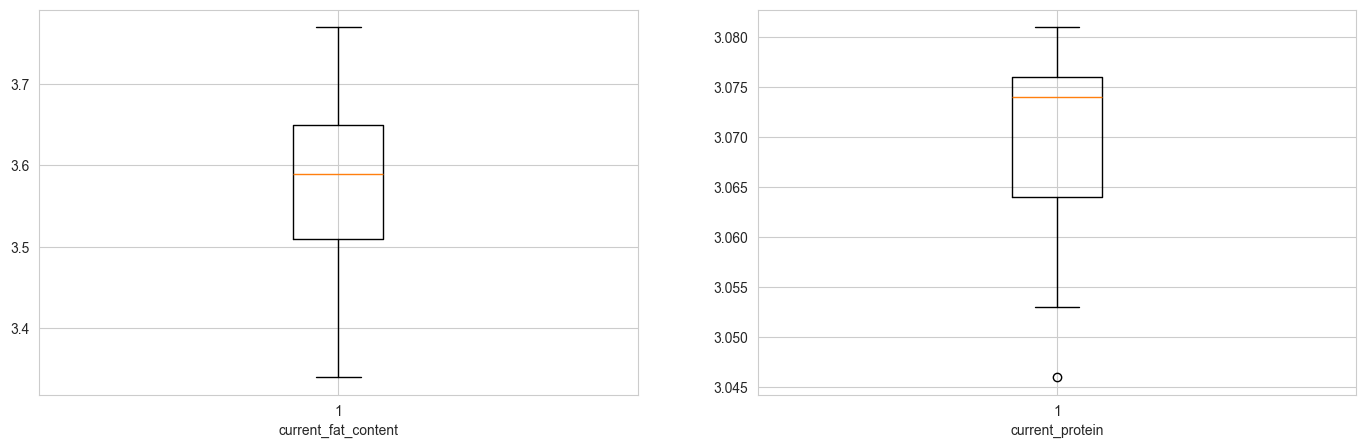

In [179]:
# Посмотрим наличие выбросов в датафрейме cow_buy
plt.figure(figsize=(17, 5))

for i in range(len(cow_buy_num_col_name)):
    plt.subplot(1, len(cow_buy_num_col_name), i + 1)
    plt.boxplot(cow_buy[cow_buy_num_col_name[i]])
    plt.xlabel(cow_buy_num_col_name[i])  # Можно ли грамотно подписать?

plt.show()

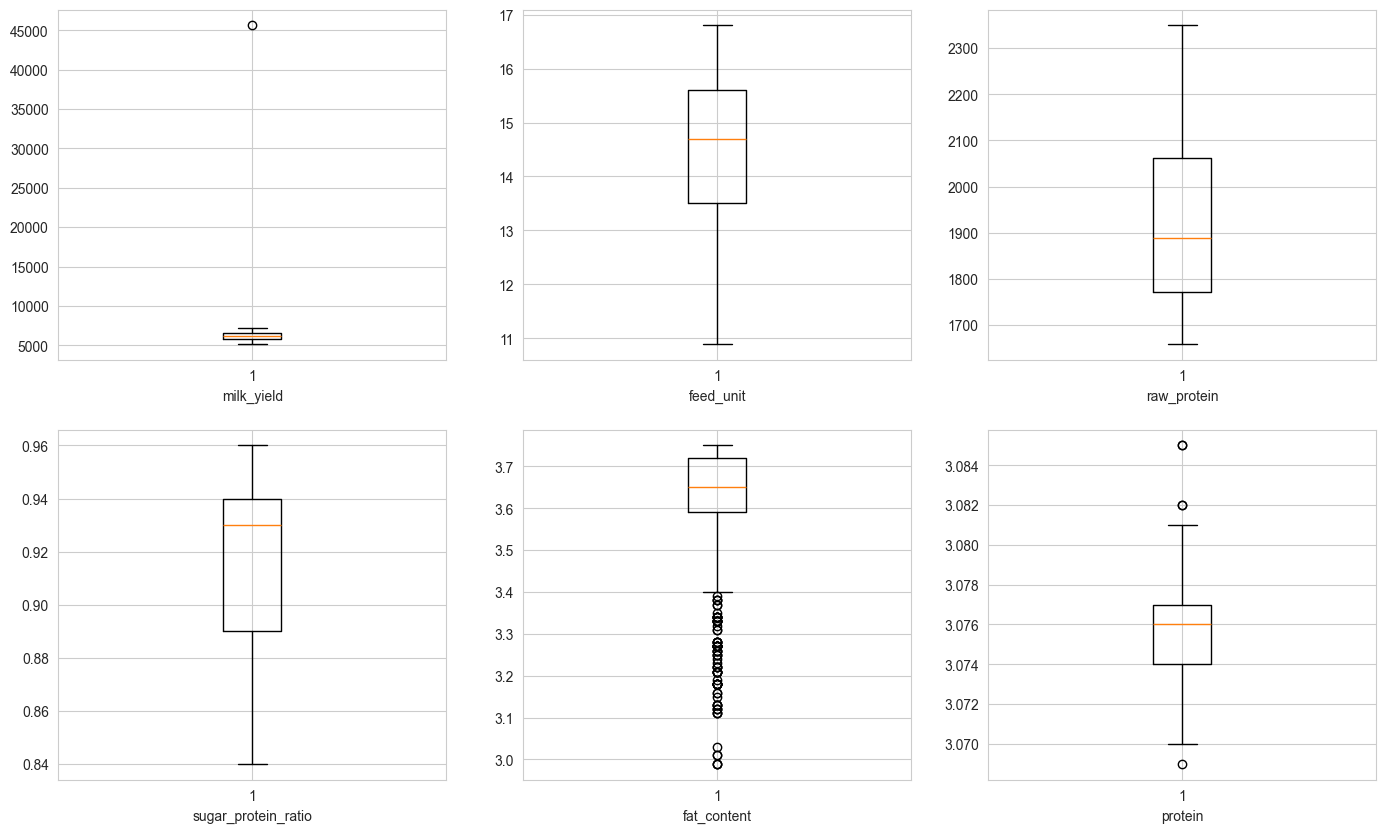

In [180]:
# Посмотрим наличие выбросов в датафрейме ferma_main
plt.figure(figsize=(17, 10))

for i in range(len(ferma_main_num_col_name)):
    plt.subplot(2, len(ferma_main_num_col_name) // 2, i + 1)
    plt.boxplot(ferma_main[ferma_main_num_col_name[i]])
    plt.xlabel(ferma_main_num_col_name[i])  # Можно ли грамотно подписать?

plt.show()

Мы видим, что у нас присутствуют выбросы в нескольких столбцах:
- `milk_yield`
- `fat_content`
- `protein`

Точно видно, что в столбце `milk_yield` выброс вызван какой-то ошибкой или невнимательностью. Удалим его. В остальных же столбцах выбросы хоть и присутсвуют, но они не очень далеки от среднего значения. В столбце `fat_content` минимальное значение отличается от среднего всего на 0.6%. Оставим эти выбросы

In [181]:
# Удаляем максимальное значение в столбце milk_yield
ferma_main = ferma_main.drop(
    ferma_main[ferma_main['milk_yield'] == ferma_main['milk_yield'].max()].index,
    axis=0,
)

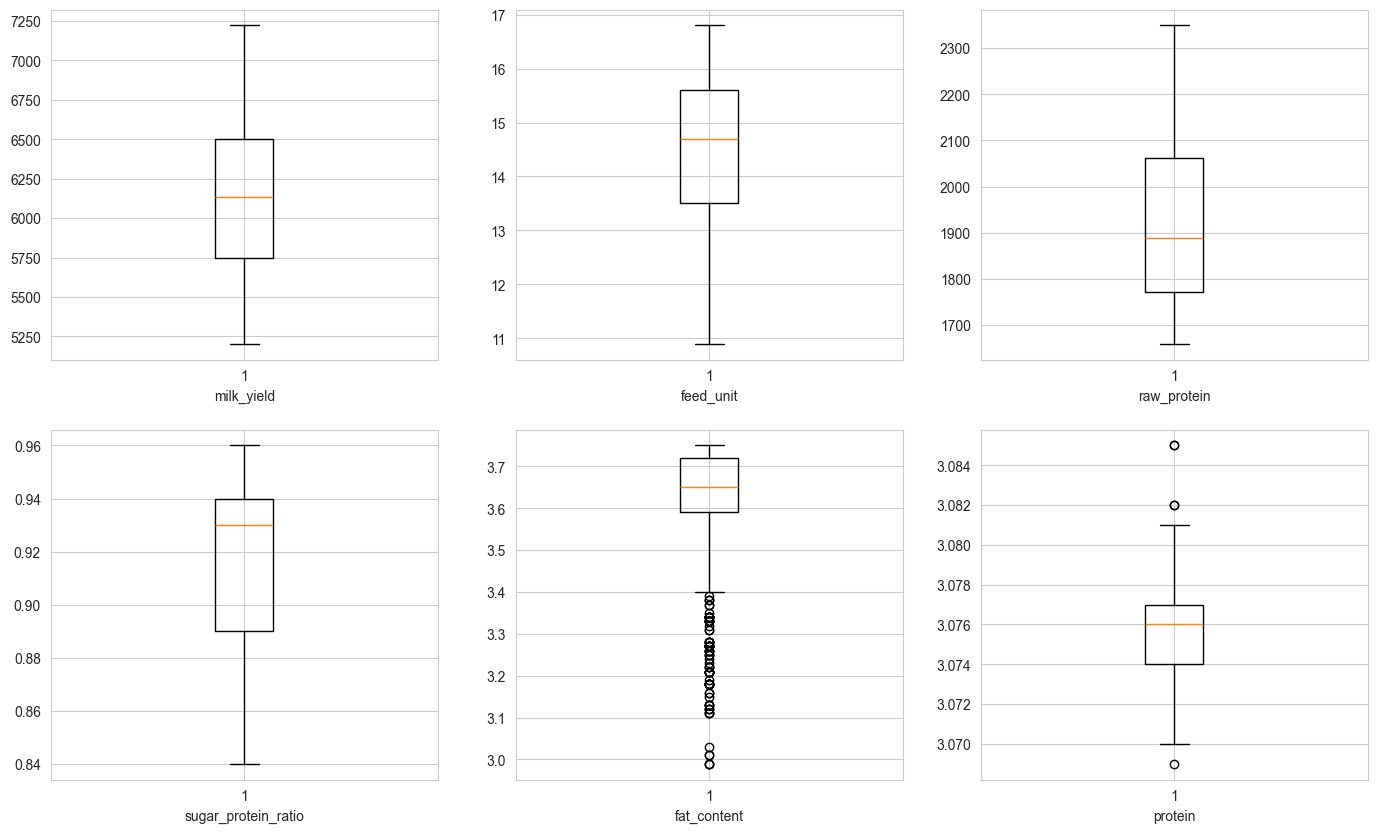

In [182]:
# Посмотрим наличие выбросов в датафрейме ferma_main
plt.figure(figsize=(17, 10))

for i in range(len(ferma_main_num_col_name)):
    plt.subplot(2, len(ferma_main_num_col_name) // 2, i + 1)
    plt.boxplot(ferma_main[ferma_main_num_col_name[i]])
    plt.xlabel(ferma_main_num_col_name[i])  # Можно ли грамотно подписать?

plt.show()

Мы удалили всего один выброс, который очевидно был вызван какой-то ошибкой.

### Вывод:
Мы преобразовали следующие столбцы:

<br>

В датафрейме `cow_buy`
- `current_fat_content` к типу `float`
- `current_protein` к типу `float`
- `age` к типу `bool`, где 1 — более 2-х лет, а 0 — менее 2 лет

<br>

В датафрейме `ferma_main`
- `feed_unit` к типу `float`
- `sugar_protein_ratio` к типу `float`
- `fat_content` к типу `float`
- `protein` к типу `float`

<br>

При обработке данных:
1. Мы создали список с названиями категориальных и числовых столбцов в датафреймах `ferma_main` и `cow_buy`
2. Мы избавились от неявных дубликатов в датафрейме `ferma_main`, а так же привели все значения к единому стилю, чтобы в дальнейшем не было проблем с созданием и применением модели.

<br>

Мы удалили всего один выброс в столбце `milk_yield` который был вызван какой-то ошибкой или невнимательностью. В остальных же столбцах выбросы хоть и присутсвуют, но они не очень далеки от среднего значения. В столбце `fat_content` минимальное значение отличается от среднего всего на 0.6%. Эти выбросы мы оставили для того, чтобы модель обучалась более разнообразных данных

## Исследовательский анализ данных
1. Проведем статистический анализ всех признаков.
2. Построим графики для каждого признака.

### Анализ числовых значений

Нарисуем гистограммы столбцов с числовыми значениями

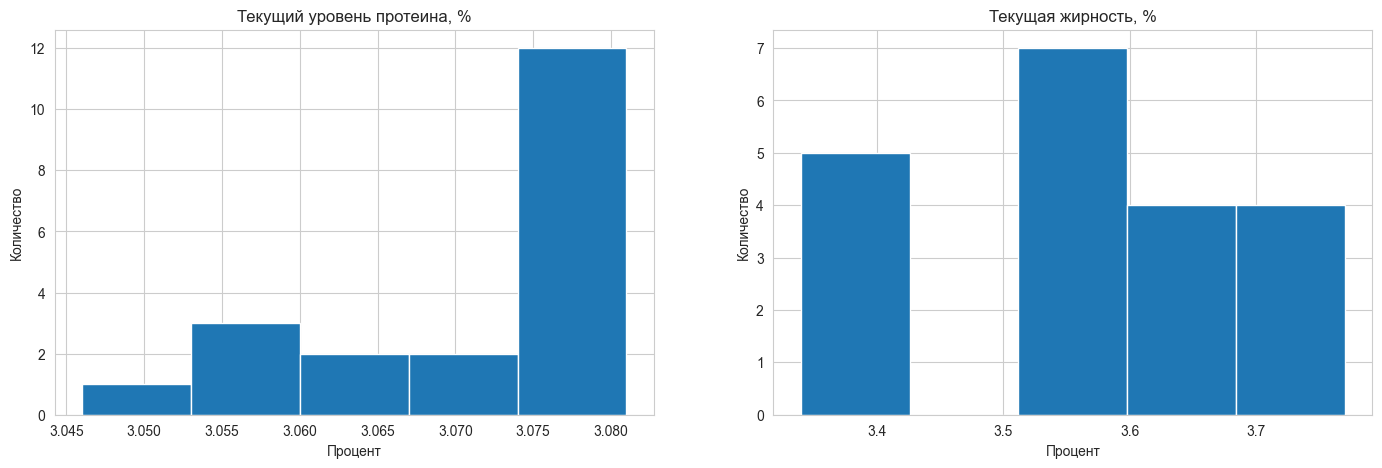

In [183]:
# Нарисуем гистограммы для числовых столбцов cow_buy
plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
plt.hist(cow_buy['current_protein'], bins=5)
plt.xlabel('Процент')
plt.ylabel('Количество')
plt.title('Текущий уровень протеина, %')

plt.subplot(1, 2, 2)
plt.hist(cow_buy['current_fat_content'], bins=5)
plt.xlabel('Процент')
plt.ylabel('Количество')
plt.title('Текущая жирность, %')

plt.show()

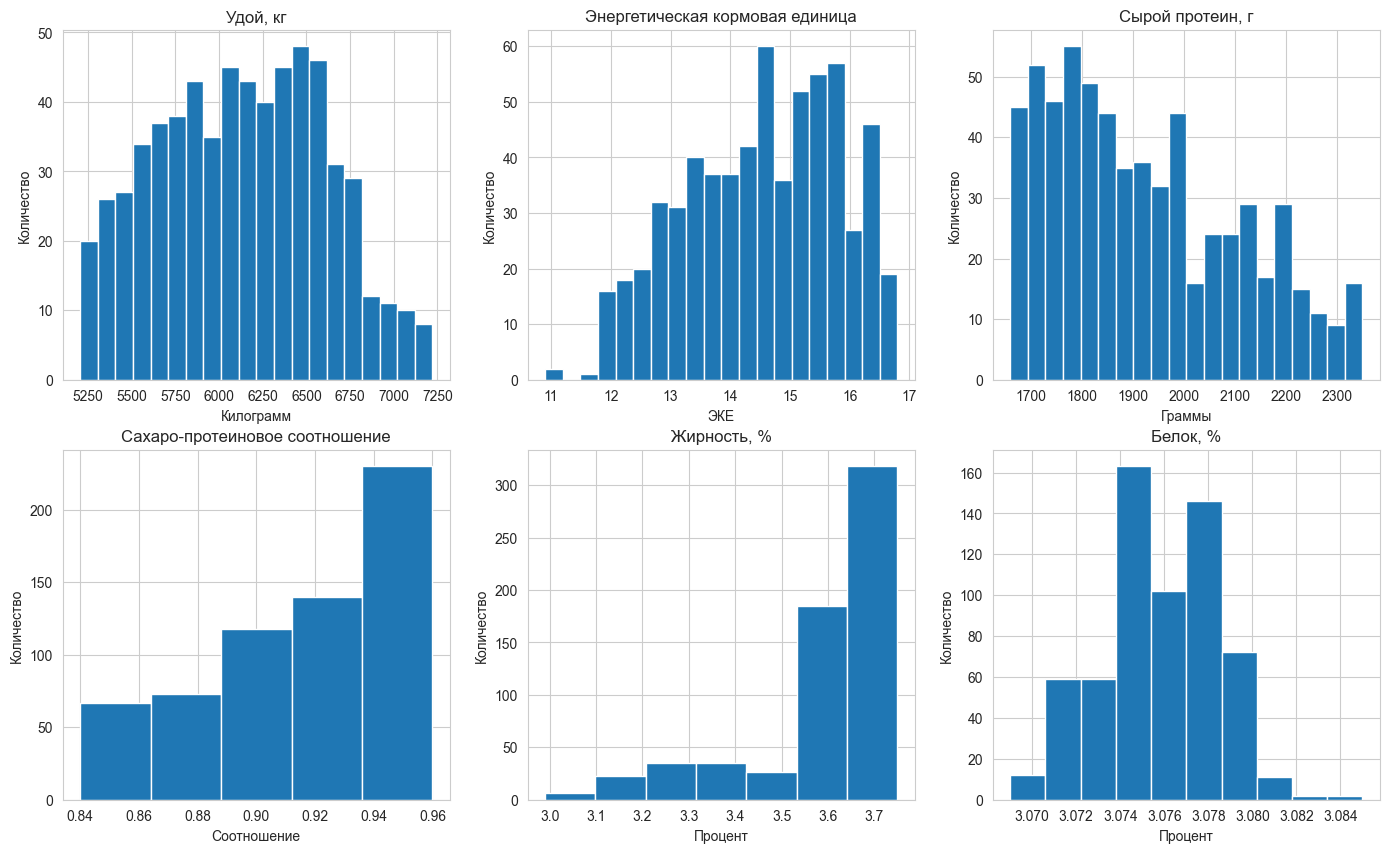

In [184]:
# Нарисуем гистограммы для числовых столбцов cow_buy
plt.figure(figsize=(17, 10))

plt.subplot(2, 3, 1)
plt.hist(ferma_main['milk_yield'], bins=20)
plt.xlabel('Килограмм')
plt.ylabel('Количество')
plt.title('Удой, кг')

plt.subplot(2, 3, 2)
plt.hist(ferma_main['feed_unit'], bins=20)
plt.xlabel('ЭКЕ')
plt.ylabel('Количество')
plt.title('Энергетическая кормовая единица')

plt.subplot(2, 3, 3)
plt.hist(ferma_main['raw_protein'], bins=20)
plt.xlabel('Граммы')
plt.ylabel('Количество')
plt.title('Сырой протеин, г')

plt.subplot(2, 3, 4)
plt.hist(ferma_main['sugar_protein_ratio'], bins=5)
plt.xlabel('Соотношение')
plt.ylabel('Количество')
plt.title('Сахаро-протеиновое соотношение')

plt.subplot(2, 3, 5)
plt.hist(ferma_main['fat_content'], bins=7)
plt.xlabel('Процент')
plt.ylabel('Количество')
plt.title('Жирность, %')

plt.subplot(2, 3, 6)
plt.hist(ferma_main['protein'], bins=10)
plt.xlabel('Процент')
plt.ylabel('Количество')
plt.title('Белок, %')

plt.show()

Мы можем отметить, что распределение данных в столбцах `Удой, кг`, `ЭКЕ` , `Белок, %` похоже на нормальное. Для столбца `Сырой протеин, г` можно сказать, что распределение похоже на распределение Пуассона. Остальные же не похожи на нормальны

### Анализ категориальных значений

Посмотрим и проанализируем категориальные значения столбцов

In [185]:
ferma_main.head(1)

,id,milk_yield,feed_unit,raw_protein,sugar_protein_ratio,breed,pasture,father_breed,fat_content,protein,milk_taste,age
0,1,5863,14.2,1743,0.89,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет


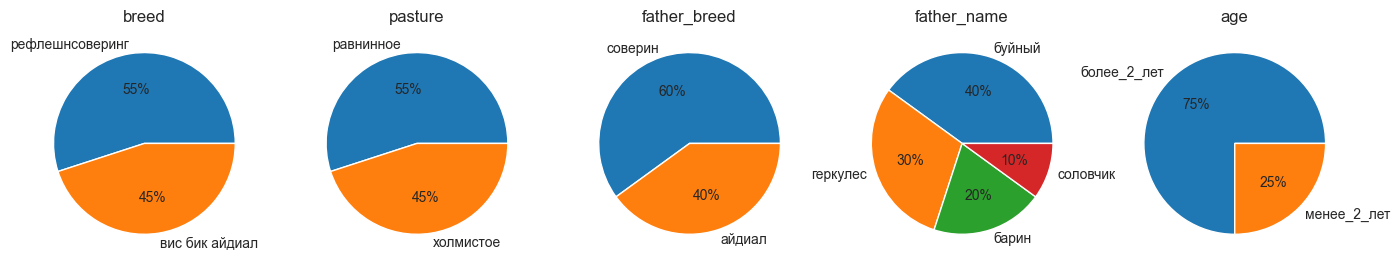

In [186]:
plt.figure(figsize=(17, 12))

for i in range(len(cow_buy_cat_col_name)):
    plt.subplot(2, len(cow_buy_cat_col_name), i + 1)
    plt.pie(cow_buy[cow_buy_cat_col_name[i]].value_counts(),
            labels=cow_buy[cow_buy_cat_col_name[i]].value_counts().index,
            autopct='%1.0f%%')
    plt.title(cow_buy_cat_col_name[i])

# plt.title('Соотношение данных о сборах фильмов')
plt.show()

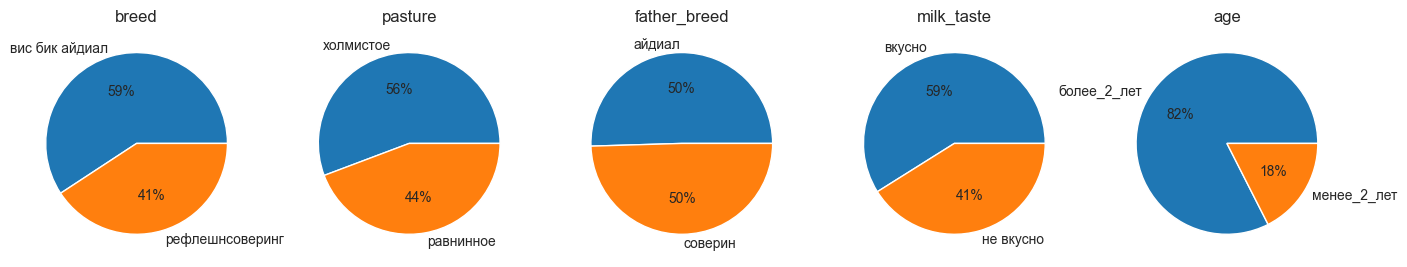

In [187]:
plt.figure(figsize=(17, 12))

for i in range(len(ferma_main_cat_col_name)):
    plt.subplot(2, len(ferma_main_cat_col_name), i + 1)
    plt.pie(ferma_main[ferma_main_cat_col_name[i]].value_counts(),
            labels=ferma_main[ferma_main_cat_col_name[i]].value_counts().index,
            autopct='%1.0f%%')
    plt.title(ferma_main_cat_col_name[i])

# plt.title('Соотношение данных о сборах фильмов')
plt.show()

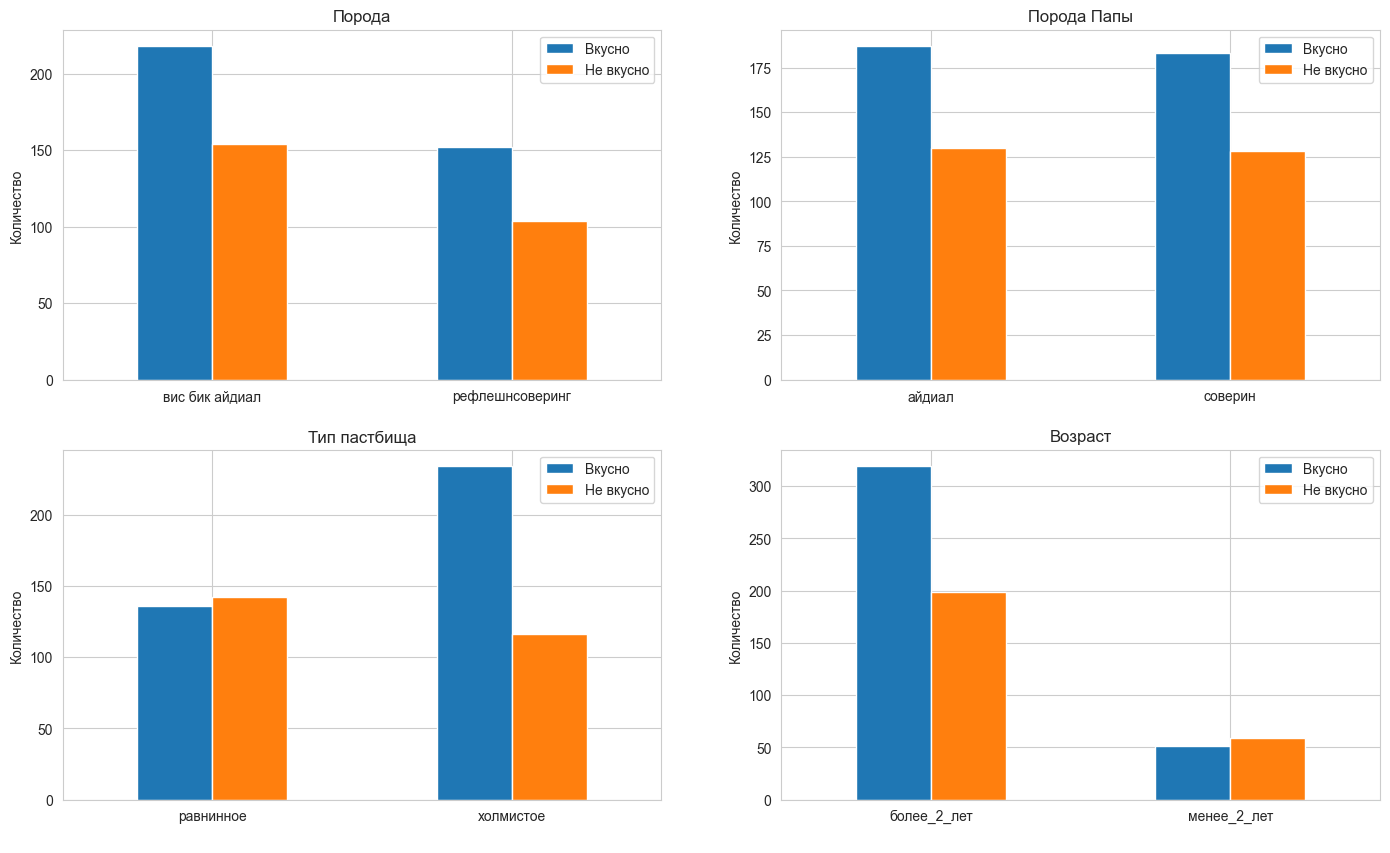

In [188]:
def draw_plot(df, col_name, ax):
    temp_pivot_table = df.pivot_table(index=df[col_name],
                                      columns='milk_taste', values='protein',
                                      aggfunc='count')
    temp_pivot_table.plot(kind='bar', ax=ax)

    # ax.xticks(rotation=0) # Почему оно здесь не работает?
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylabel('Количество')
    ax.set_xlabel(' ')
    ax.legend(['Вкусно', 'Не вкусно'])

#     ax.bar_label(ax.containers[0], label_type='edge')
#     ax.bar_label(ax.containers[1], label_type='edge')


fig, axs = plt.subplots(2, 2, figsize=(17, 10))

draw_plot(ferma_main, ferma_main_cat_col_name[0], axs[0, 0])
axs[0, 0].set_title('Порода')

draw_plot(ferma_main, ferma_main_cat_col_name[2], axs[0, 1])
axs[0, 1].set_title('Порода Папы')

draw_plot(ferma_main, ferma_main_cat_col_name[1], axs[1, 0])
axs[1, 0].set_title('Тип пастбища')

draw_plot(ferma_main, ferma_main_cat_col_name[4], axs[1, 1])
axs[1, 1].set_title('Возраст')

plt.show()

### Вывод:

Во время исследовательского анализа числовых столбцов, мы увидели, что столбцы `Удой, кг` и `Белок, %` распределены нормально. Какой-то закономерности в остальных столбцах мы не наблюдаем.

<br>

В категориальных столбцах мы видим, что у фермера преобладает коровы со вкусным молоком. Так же 90% коров старше 2-х лет. Вкус молока не особо зависит от породы, пастбища, или же породы отца. Можно выделить, что слегка более вкусное молоко у породы `вис бик айдиал`. Так же стоит отметить, что у коров, которые паслись на `холмистом` пастбище, молоко сильно вкуснее

## Корреляционный анализ
Проведем корреляционный анализ признаков в датасете `ferma_main.csv`
1. Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками.
2. Построим диаграммы рассеяния `scatterplot` для признака `Удой, кг` и всех количественных признаков с учётом значения категориальных признаков. Пример: диаграмма рассеяния для `Удой, кг` и `Сырой протеин, г`, цвет точек диаграммы отображает признак `Порода`. Учитывайте, что виды связи в подгруппах могут различаться — например, для разных пород.

interval columns not set, guessing: ['id', 'milk_yield', 'feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']


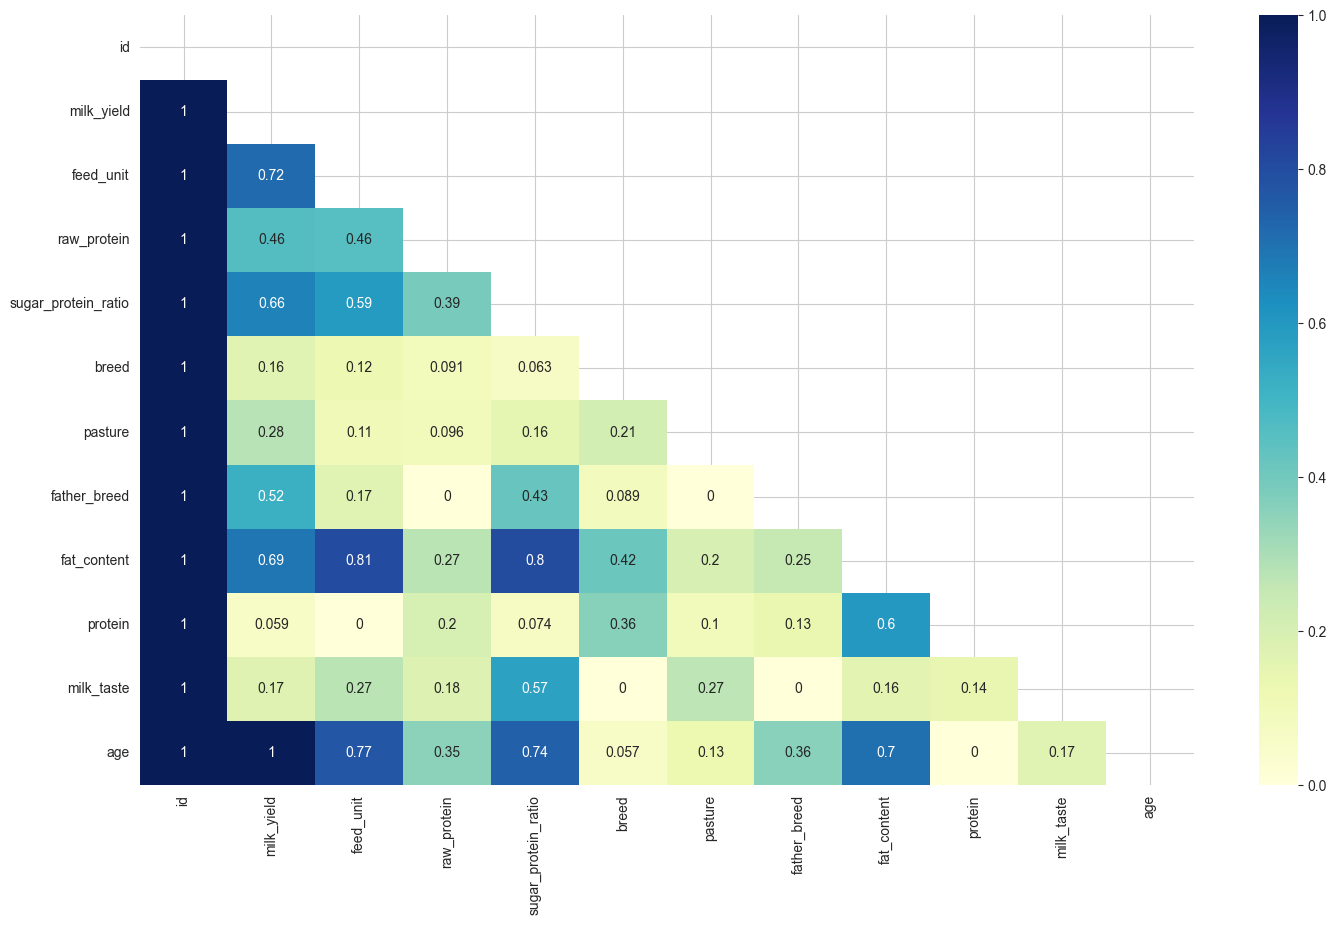

In [189]:
# Создадим хитмап корреляции
plt.figure(figsize=(17, 10))

sns.heatmap(
    ferma_main.phik_matrix(
        interval_cols=['milk_yield', 'feed_unit', 'raw_protein', 'sugar_protein_ratio', 'protein'],
    ),
    annot=True, cmap='YlGnBu',
    mask=(np.triu(np.ones_like(ferma_main.phik_matrix(), dtype=bool)))
)

plt.show()

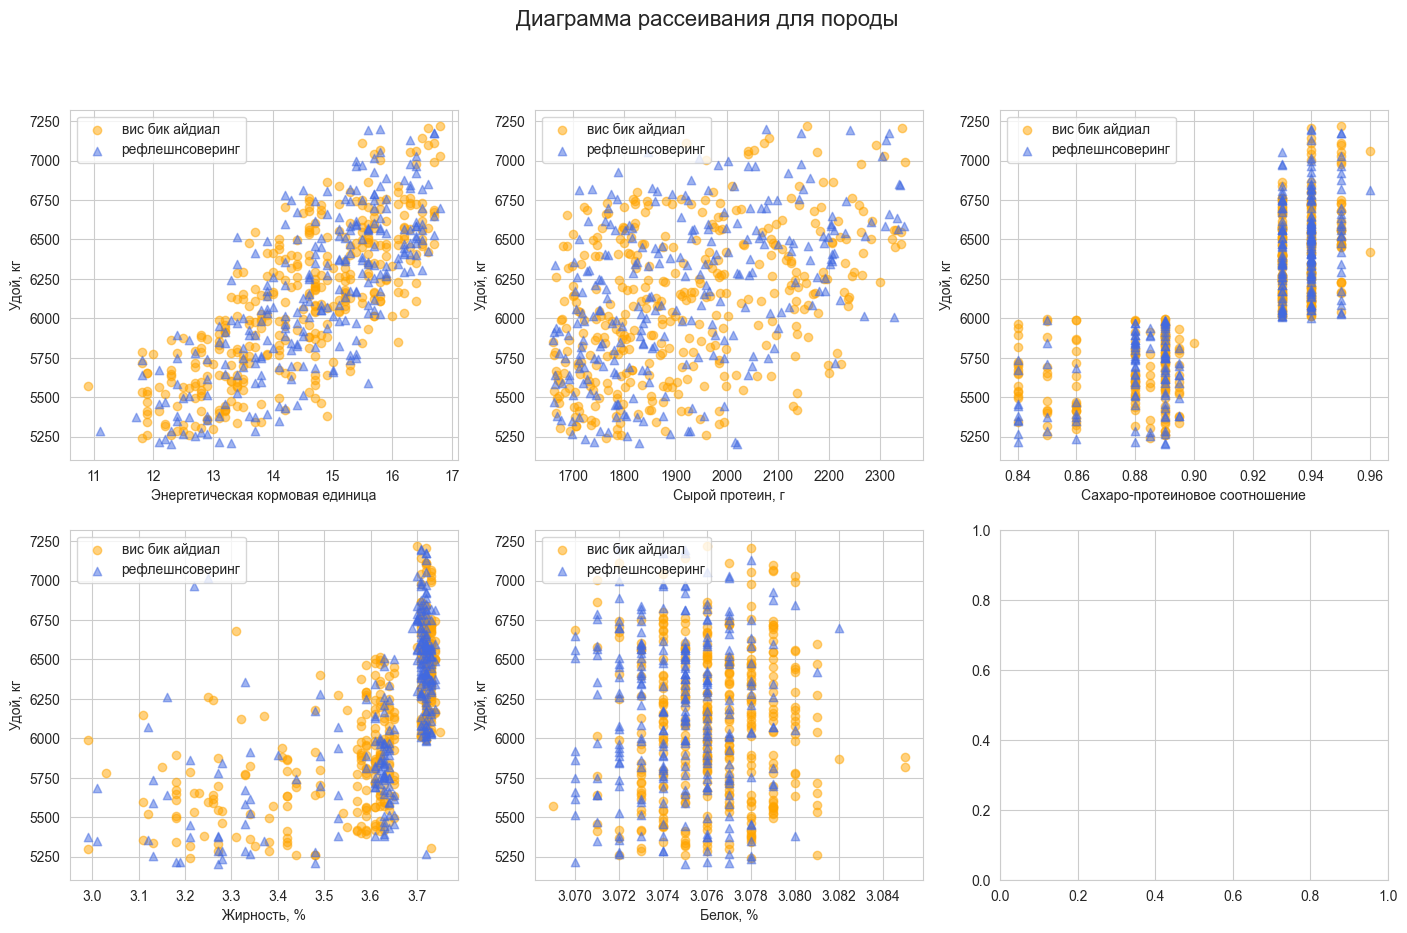

In [190]:
# Создадим функцию, которая будет рисовать диаграмму рассеивания
def draw_scatter(df, col_name, ax, subgroup):
    ax.scatter(x=df[df[subgroup] == df[subgroup].unique()[0]][col_name],
               y=df[df[subgroup] == df[subgroup].unique()[0]]['milk_yield'],
               c='orange', marker='o', alpha=0.5)

    ax.scatter(x=df[df[subgroup] == df[subgroup].unique()[1]][col_name],
               y=df[df[subgroup] == df[subgroup].unique()[1]]['milk_yield'],
               c='royalblue', marker='^', alpha=0.5)

    ax.set_ylabel('Удой, кг')
    ax.legend(labels=df[subgroup].unique(), loc='upper left')


fig, axs = plt.subplots(2, 3, figsize=(17, 10))
fig.suptitle('Диаграмма рассеивания для породы', fontsize=16)
# plt.style.use('dark_background')

# Задаем подгруппу
subgroup = 'breed'

draw_scatter(ferma_main, ferma_main_num_col_name[1], axs[0, 0], subgroup=subgroup)
axs[0, 0].set_xlabel('Энергетическая кормовая единица')

draw_scatter(ferma_main, ferma_main_num_col_name[2], axs[0, 1], subgroup=subgroup)
axs[0, 1].set_xlabel('Сырой протеин, г')

draw_scatter(ferma_main, ferma_main_num_col_name[3], axs[0, 2], subgroup=subgroup)
axs[0, 2].set_xlabel('Сахаро-протеиновое соотношение')

draw_scatter(ferma_main, ferma_main_num_col_name[4], axs[1, 0], subgroup=subgroup)
axs[1, 0].set_xlabel('Жирность, %')

draw_scatter(ferma_main, ferma_main_num_col_name[5], axs[1, 1], subgroup=subgroup)
axs[1, 1].set_xlabel('Белок, %')

plt.show()

Мы видим, что данные распределены равномерно. Можно отметить, что жирность у породы `вис бик айдиал` в среднем меньше, чем у `рефлешнсоверинг`. А так же процент белка `вис бик айдиал` в среднем больше, чем у `рефлешнсоверинг`

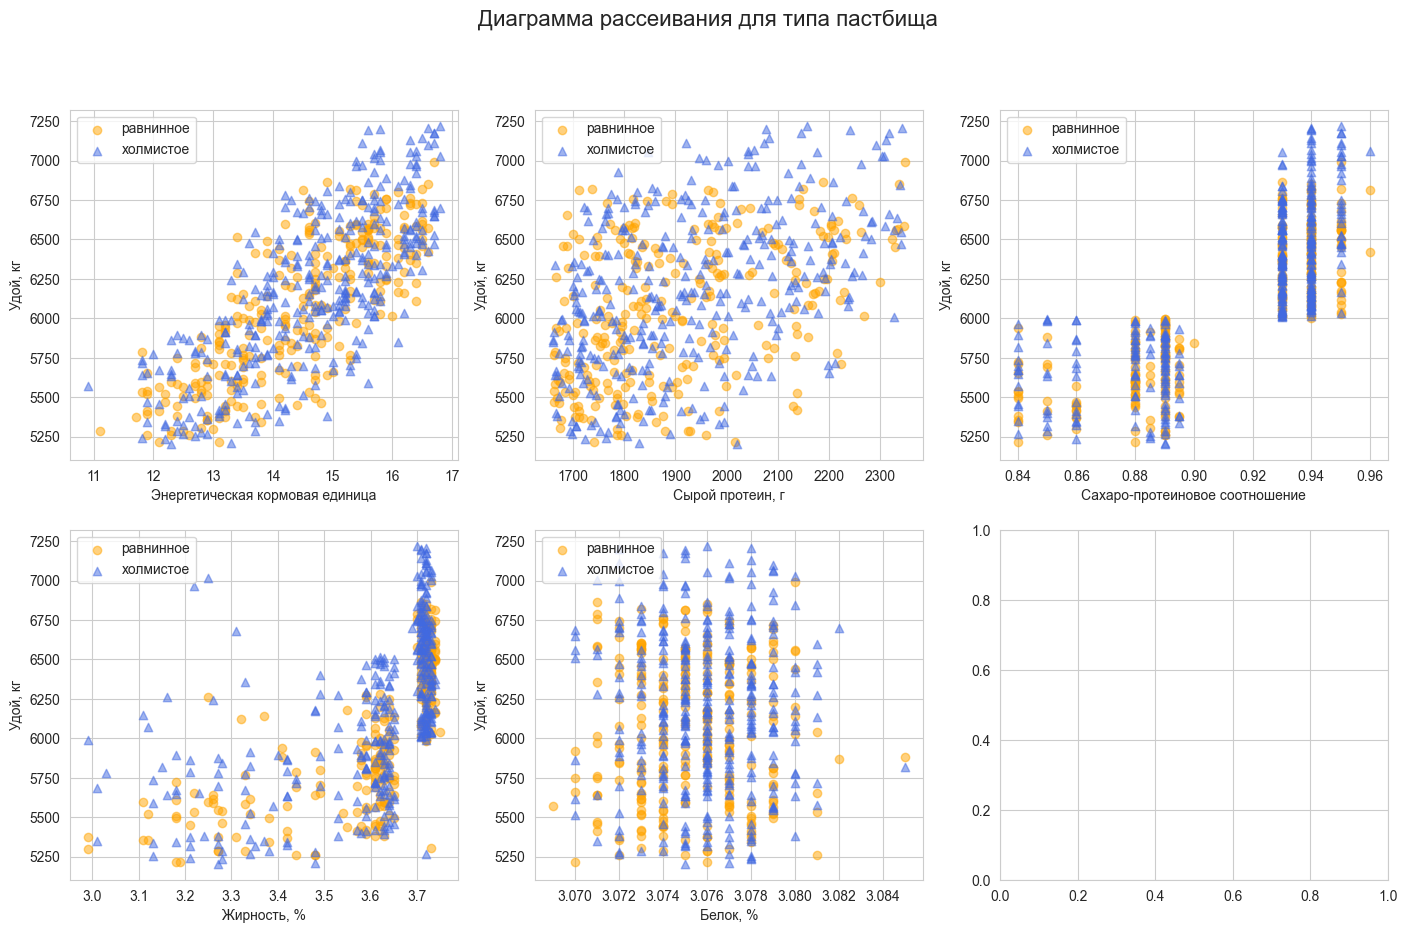

In [191]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))
fig.suptitle('Диаграмма рассеивания для типа пастбища', fontsize=16)
# plt.style.use('dark_background')

subgroup = 'pasture'

draw_scatter(ferma_main, ferma_main_num_col_name[1], axs[0, 0], subgroup=subgroup)
axs[0, 0].set_xlabel('Энергетическая кормовая единица')

draw_scatter(ferma_main, ferma_main_num_col_name[2], axs[0, 1], subgroup=subgroup)
axs[0, 1].set_xlabel('Сырой протеин, г')

draw_scatter(ferma_main, ferma_main_num_col_name[3], axs[0, 2], subgroup=subgroup)
axs[0, 2].set_xlabel('Сахаро-протеиновое соотношение')

draw_scatter(ferma_main, ferma_main_num_col_name[4], axs[1, 0], subgroup=subgroup)
axs[1, 0].set_xlabel('Жирность, %')

draw_scatter(ferma_main, ferma_main_num_col_name[5], axs[1, 1], subgroup=subgroup)
axs[1, 1].set_xlabel('Белок, %')

plt.show()

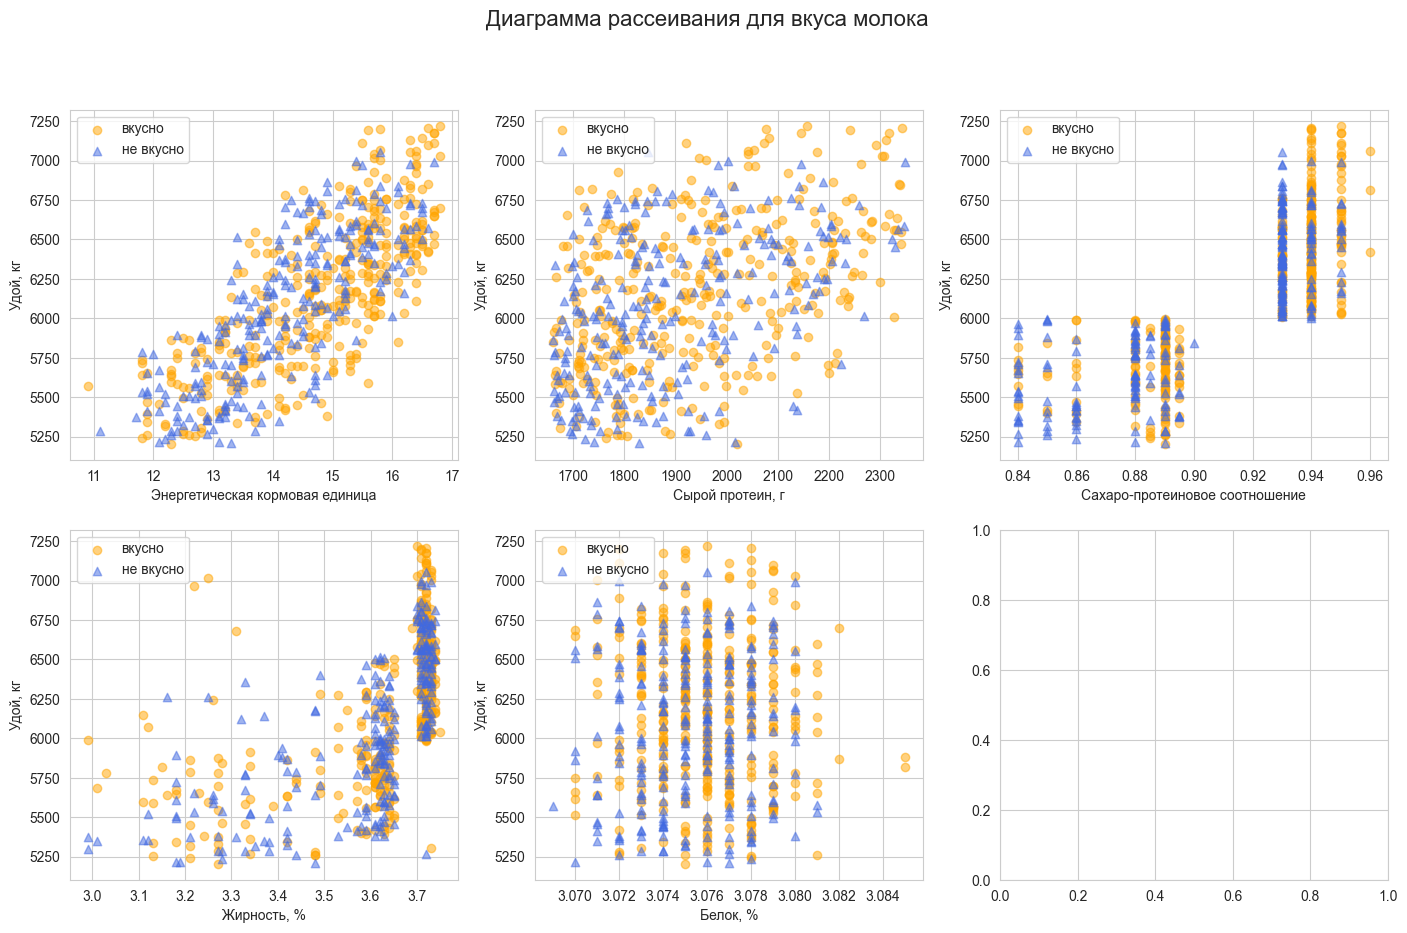

In [192]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))
fig.suptitle('Диаграмма рассеивания для вкуса молока', fontsize=16)
# plt.style.use('dark_background')

subgroup = 'milk_taste'

draw_scatter(ferma_main, ferma_main_num_col_name[1], axs[0, 0], subgroup=subgroup)
axs[0, 0].set_xlabel('Энергетическая кормовая единица')

draw_scatter(ferma_main, ferma_main_num_col_name[2], axs[0, 1], subgroup=subgroup)
axs[0, 1].set_xlabel('Сырой протеин, г')

draw_scatter(ferma_main, ferma_main_num_col_name[3], axs[0, 2], subgroup=subgroup)
axs[0, 2].set_xlabel('Сахаро-протеиновое соотношение')

draw_scatter(ferma_main, ferma_main_num_col_name[4], axs[1, 0], subgroup=subgroup)
axs[1, 0].set_xlabel('Жирность, %')

draw_scatter(ferma_main, ferma_main_num_col_name[5], axs[1, 1], subgroup=subgroup)
axs[1, 1].set_xlabel('Белок, %')

plt.show()

Можно отметить, что чем выше `удой` и `ЭКЕ`, тем вкуснее молоко. Чем больше `жирность`, тем вкуснее молоко

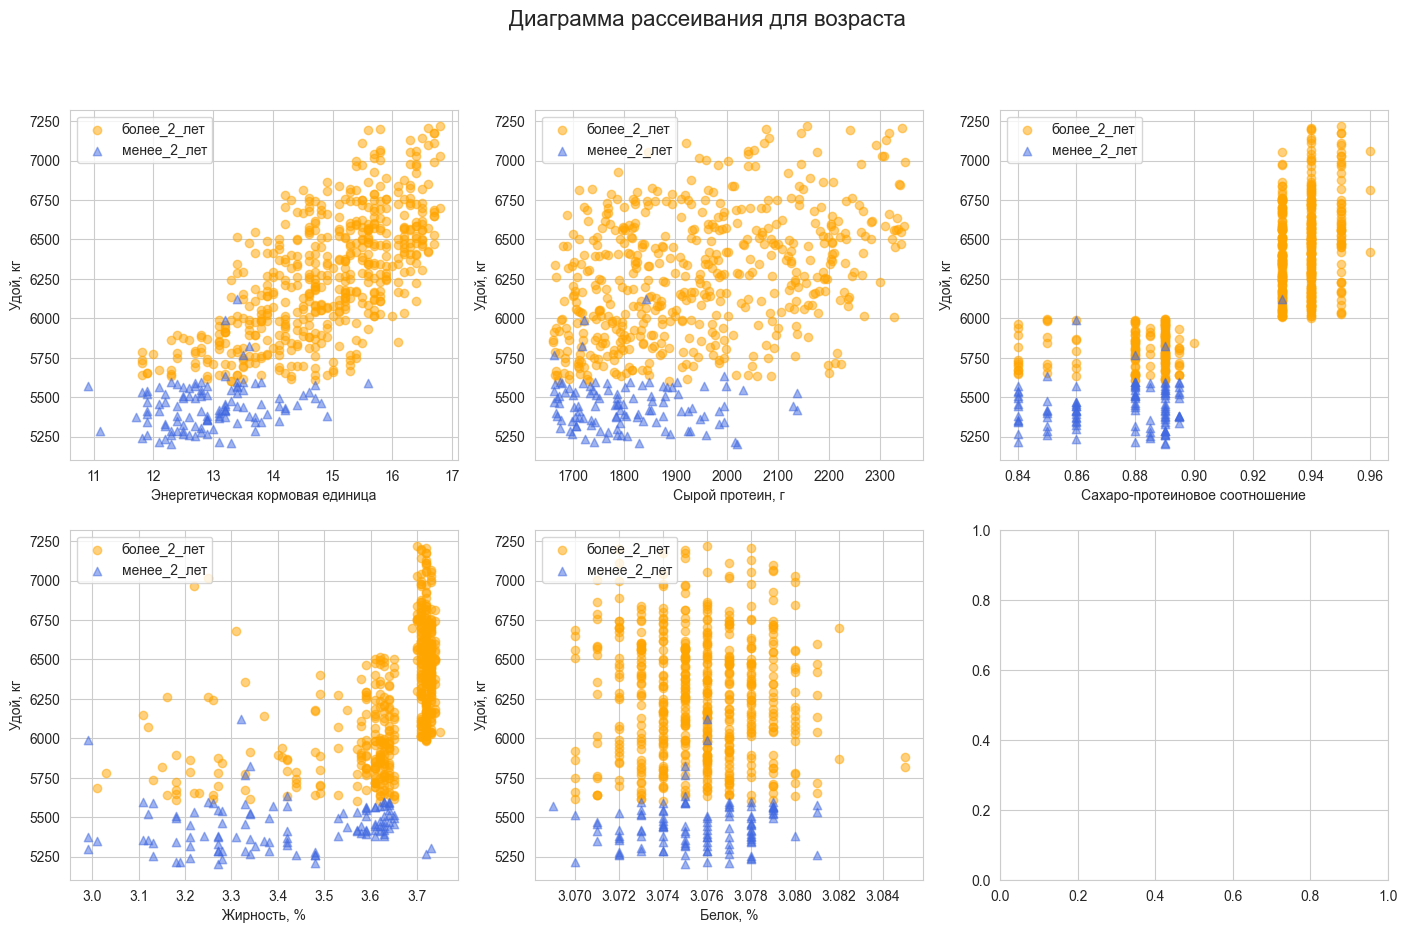

In [193]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))
fig.suptitle('Диаграмма рассеивания для возраста', fontsize=16)
# plt.style.use('dark_background')

subgroup = 'age'

draw_scatter(ferma_main, ferma_main_num_col_name[1], axs[0, 0], subgroup=subgroup)
axs[0, 0].set_xlabel('Энергетическая кормовая единица')

draw_scatter(ferma_main, ferma_main_num_col_name[2], axs[0, 1], subgroup=subgroup)
axs[0, 1].set_xlabel('Сырой протеин, г')

draw_scatter(ferma_main, ferma_main_num_col_name[3], axs[0, 2], subgroup=subgroup)
axs[0, 2].set_xlabel('Сахаро-протеиновое соотношение')

draw_scatter(ferma_main, ferma_main_num_col_name[4], axs[1, 0], subgroup=subgroup)
axs[1, 0].set_xlabel('Жирность, %')

draw_scatter(ferma_main, ferma_main_num_col_name[5], axs[1, 1], subgroup=subgroup)
axs[1, 1].set_xlabel('Белок, %')

plt.show()

Мы можем видеть, что все показатели у коров старше 2-х лет выше. Это может быть вызвано еще и недостатком данных, ибо как мы видели ранее, количество коров младше 2-х лет составляет всего 10%.

<br>

Если абстрагироваться от разделения на признаки, то мы можем сказать, что для признака `Удой, кг` самая высокая корреляция с признаком `ЭКЕ`. Мы так же можем сказать, что для признака `Белок, %` связь с признаком `Удой, кг` нелинейна

### Вывод:

Рассмотрим колляцию между признаком `Удой` и другими числовыми признаками.
 - `Энергетическая кормовая единица`: корреляция положительная и ее коэффициент составляет `0.72`
 - `Сырой протеин, г`: корреляция положительна и ее коэффициент составляет `0.4`
 - `Сахаро-протеиновое соотношение`: корреляция положительна и ее коэффициент составляет `0.67`. Стоит отметить, что корреляция не является линейной, ибо мы видим 2 кластера. Мы можем наблюдать пропуск в диапазоне от `0.9` до `0.93`
 - `Жирность, %`: корреляция положительна и ее коэффициент составляет `0.68`. Идентично предыдущему признаку, мы можем наблюдать "пробел" в данных
 - `Белок, %`: корреляция положительна и ее коэффициент составляет `0.18`. Отметим, что корреляция совершенно нелинейна

Мы видим, что данные распределены равномерно. Можно отметить, что жирность у породы `вис бик айдиал` в среднем меньше, чем у `рефлешнсоверинг`. А так же процент белка `вис бик айдиал` в среднем больше, чем у `рефлешнсоверинг`

<br>

Можно отметить, что чем выше `удой` и `ЭКЕ`, тем вкуснее молоко. Чем больше `жирность`, тем вкуснее молоко

<br>

Мы можем видеть, что все показатели у коров старше 2-х лет выше. Это может быть вызвано еще и недостатком данных, ибо как мы видели ранее, количество коров младше 2-х лет составляет всего 10%.

<br>

Если абстрагироваться от разделения на признаки, то мы можем сказать, что для признака `Удой, кг` самая высокая корреляция с признаком `ЭКЕ`. Мы так же можем сказать, что для признака `Белок, %` связь с признаком `Удой, кг` свзяь отсутсвуют

## Обучение модели линейной регрессии

Нам предстоит обучить три модели простой линейной регрессии.
1. Подготовим данные датасета `ferma_main.csv` и обучим на них первую модель `LinearRegression`.
    - Используем в качестве целевого признак `Удой, кг`.
    - Отберем признаки, которые подходят для модели линейной регрессии, аргументируйте выбор. Будем опираться не только на наличие или отсутствие линейной связи между признаками, но и на причинно-следственные связи между удоем коров и группами признаков из описания датасета.
    - Разобьем данные на тренировочную и тестовую выборки.
    - Кодируем категориальные признаки с помощью `OneHotEncoder`.
    - Масштабируем количественные признаки с помощью `StandardScaler`.
    - Обучим модель линейной регрессии на подготовленных данных.
    - Оценим качество модели на тестовой выборке: рассчитаем R², проанализируем остатки с помощью графиков.
    - Оформим выводы, укажем:
        - значение R² модели;
        - какие выводы следуют из анализа остатков;
        - нужны ли дополнительные исследования.
2. Подготовим данные с учётом связи входных признаков с целевым и обучим на них вторую модель `LinearRegression`.
    - Посмотрим на диаграммы рассеяния: на них можно увидеть, что некоторые входные признаки связаны с целевым нелинейно. Исключим нелинейность, чтобы эти признаки были информативны для линейной регрессии. Вот несколько способов, которыми это можно сделать:
        - Мы обнаружили, что `СПО` и `Удой` связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение `СПО`, которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуем `СПО` в категориальный бинарный признак, использовав эту границу.
        - Мы обнаружили, что `ЭКЕ` и `Удой` также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак `ЭКЕ в квадрате`.
    - Повторим шаги из пункта 1 и создадим вторую модель: подготовим данные, обучим модель, оценим её качество и напишем выводы.
3. Добавим в данные новый признак и обучим на них третью модель `LinearRegression`.
    - Добавим признак `Имя Папы` из файла `ferma_dad.csv`, соединив его с остальными данными `ferma_main.csv` по ключу.
    - Устраним нелинейность между признаками.
    - Повторим шаги из пункта 1 и создадим третью модель: подготовим данные, обучим модель, оценим её качество и напишем выводы.
4. Сравним качество трёх моделей линейной регрессии, сопоставим их R² и остатки.
5. Оценим качество каждой модели по трём метрикам: MSE, MAE, RMSE. Используем функции для расчёта метрик.
    - Выберем лучшую модель;
    - Укажем доверительный интервал прогноза лучшей модели. Для этого рассчитаем квантили ошибки модели на тренировочных данных.
6. С помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить. Данные о них находятся в датасете `cow_buy.csv`.
    - Добавим недостающие признаки `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)`: возьмем из датасета `ferma_main.csv` средние значения каждого из признаков и увеличьте их на 5%.
    - Выполним подготовку данных, аналогичную той, которую делали для тренировочной выборки.
    - Получим прогноз удоя коров.

Перед разделением на выборки, определим лишние столбцы, которые не влияют на целевой признак.
- `id`, потому что это уникальный номер
- `Жирность, %`, потому что это характеристика молока, а не корма
- `Белок, %`, потому что это характеристика молока, а не корма

Создадим функцию, которая будет получать на вход данные, целевой признак, числовые столбцы, категориальные столбцы. На выходе мы будем получать метрики `MSE`,`RMSE`,`MAE`,`R2_score`, а так же будет рисовать гистограмму остатков и дисперсию

In [194]:
cow_buy = cow_buy.rename(columns={'current_fat_content': 'fat_content',
                                  'current_protein': 'protein'})

In [195]:
# Создаем функцию
def create_linear_model(X: pd.DataFrame, y: pd.DataFrame, num_col_name: list, cat_col_name: list):
    # Разбиваем данные на выборки
    global X_train, y_train
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        random_state=42)

    # Кодируем данные
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_name])
    X_test_ohe = encoder.transform(X_test[cat_col_name])
    encoder_col_names = encoder.get_feature_names_out()

    # Масштабируем данные
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_name])
    X_test_scaled = scaler.transform(X_test[num_col_name])

    # Собираем выборки
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_name)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_name)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    # Обучение модели
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    # global prediction # Объявляем переменную глобально, чтобы потом могли ее использовать
    prediction = model_lr.predict(X_test)

    # Создаем глобальную переменную, которая будет хранить веса модели
    global weights
    weights = np.append(model_lr.coef_, model_lr.intercept_)

    # Оценка модели
    mse = mean_squared_error(y_test, prediction)
#     rmse = root_mean_squared_error(y_test, prediction)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)

    residuals = prediction - y_test

    fig, axs = plt.subplots(1, 2, figsize=(17, 5))

    # Рисуем гистограмму остатков
    axs[0].hist(residuals, bins=30, color='royalblue')
    axs[0].vlines(x=0,
                  ymin=0,
                  ymax=(axs[0].hist(residuals, bins=30)[0]).max(),
                  color='red', linestyles='--',
                  label='Ноль')
    axs[0].vlines(x=residuals.mean(),
                  ymin=0,
                  ymax=(axs[0].hist(residuals, bins=30)[0]).max(),
                  color='green',
                  label='Среднее')
    axs[0].set_title('Распределение остатков')
    axs[0].set_xlabel('Остатки')

    axs[1].scatter(prediction, residuals, color='royalblue')
    axs[1].set_title('Дисперсия')
    axs[1].set_xlabel('Предсказания')
    axs[1].set_ylabel('Остатки')

    plt.show()

    print(f'MAE: {mae:.5f}')
    print(f'R2_score: {r2:.5f}')
    print('95% доверительный интервал =',
          stats.norm.interval(confidence=0.95, loc=np.mean(prediction), scale=stats.sem(prediction)))
    return mse, rmse, mae, r2, residuals.median()

In [196]:
# Создаем таблицу со значениями метрик для разных моделей
metrics_df = pd.DataFrame(columns=['mse', 'rmse', 'mae', 'r2', 'residuals'])

### Модель №1

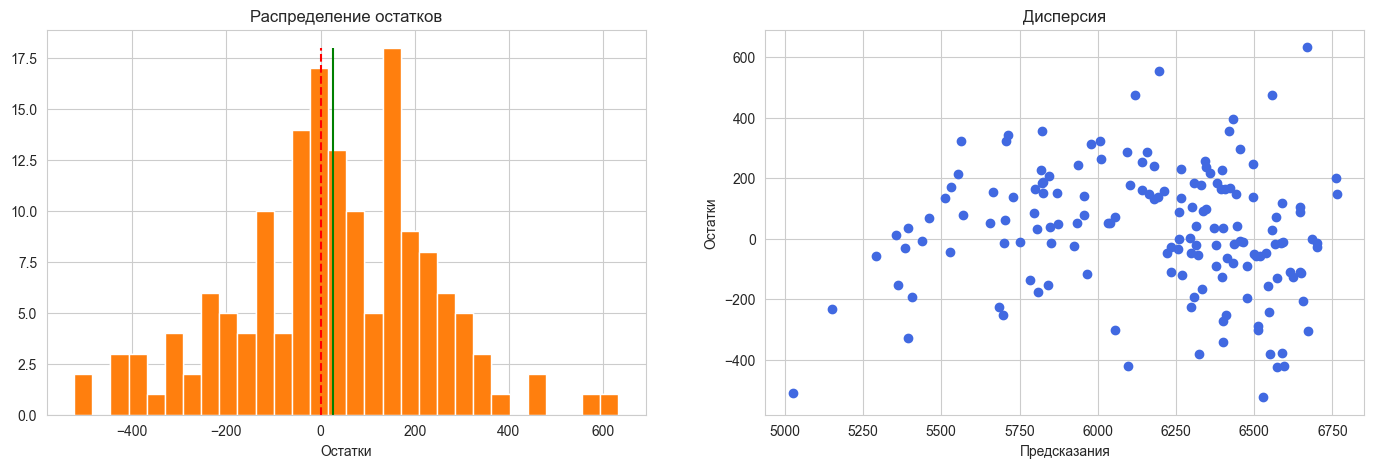

MAE: 164.24194
R2_score: 0.78441
95% доверительный интервал = (np.float64(6106.009965598841), np.float64(6228.04870872839))


In [197]:
cat_col_name = ['breed', 'pasture', 'father_breed', 'age']
num_col_name = ['feed_unit', 'raw_protein', 'sugar_protein_ratio']

X = ferma_main.drop(['id', 'milk_yield', 'fat_content', 'protein'], axis=1)
y = ferma_main['milk_yield']

# Добавим значения ошибок в таблицу, чтобы позже сравнить значения
metrics_df.loc[0] = create_linear_model(X, y, num_col_name, cat_col_name)

Мы можем видеть, что в распределении диспресии у нас нет никакх закономерностей. Дисперсия не походит ни на рупор, ни на дугу, а среднее остатков немного смещено вправо. Остатки модели распределены не нормально. R2_score составляет `0.78441`, что довольно далеко от 1, модель работает не очень хорошо. Согласно Mean Absolut Error среднем модель ошибается на `164 кг`

### Модель №2

Когда мы проводили корреляционный анализ, мы обнаружили, что признаки `Сахаро-протеиновое соотношение` и `Энергетическая кормовая единица` связаны нелинейно.
- Для признака `СПО` мы можем устранить нелинейность, преобразовав ее в бинарный категориальный признак. Согласно графику, мы можем определить границу в `0.92`
- Для признака `ЭКЕ` мы можем устранить нелинейность, возведя это в квадрат. На диаграмме разброса мы видели, что эта характеристика связана с целевой линейно, но разброс данных слишком большой

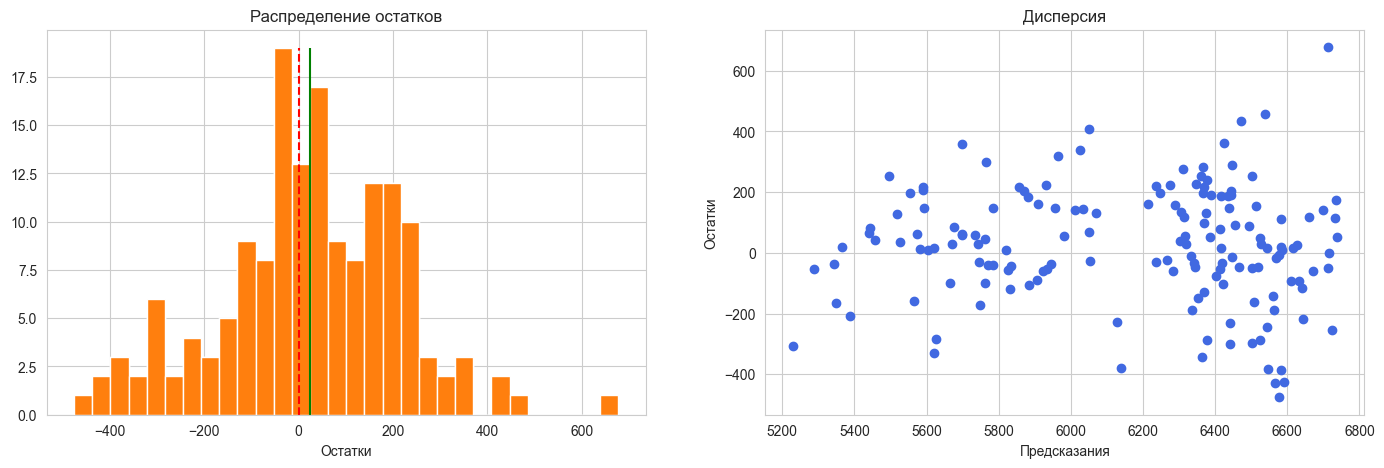

MAE: 149.03965
R2_score: 0.81809
95% доверительный интервал = (np.float64(6103.09954488274), np.float64(6228.958153299152))


In [198]:
# Создаем категориальный столбец для ЭКЕ
ferma_main['sugar_protein_ratio_cat'] = ferma_main['sugar_protein_ratio'].apply(lambda x: 1 if x > 0.92 else 0)

# Создаем столбец с ЭКЕ, возведенным в квадрат
ferma_main['feed_unit_squared'] = ferma_main['feed_unit'] ** 2

cat_col_name = ['breed', 'pasture', 'father_breed', 'age', 'sugar_protein_ratio_cat']
num_col_name = ['feed_unit_squared', 'raw_protein']

X = ferma_main.drop(['id', 'milk_yield', 'fat_content', 'protein', 'feed_unit', 'sugar_protein_ratio'], axis=1)
y = ferma_main['milk_yield']

# Добавим значения ошибок в таблицу, чтобы позже сравнить значения
metrics_df.loc[1] = create_linear_model(X, y, num_col_name, cat_col_name)

Мы видим, что у нас гистограмма распределения остатков стала больше походить на нормальное распределение, метрика R2_score чуть-чуть возросла, а MAE и RMSE чуть-чуть упали, однако в общем модель все еще не очень хорошо предсказывает целевой признак

### Модель №3

Добавим в столбец еще один признак из таблицы `ferma_dad`

In [199]:
# Посмотрим на размерность перед соединением таблиц
ferma_main.shape

(628, 14)

In [200]:
ferma_main = ferma_main.merge(ferma_dad, on='id').reset_index(drop=True)
print(ferma_main.shape)
ferma_main.head()

(628, 15)


,id,milk_yield,feed_unit,raw_protein,sugar_protein_ratio,breed,pasture,father_breed,fat_content,protein,milk_taste,age,sugar_protein_ratio_cat,feed_unit_squared,father_name
0,1,5863,14.2,1743,0.890,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,буйный
1,2,5529,12.8,2138,0.890,вис бик айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,соловчик
2,3,5810,14.0,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,барин
3,4,5895,12.4,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,буйный
4,5,5302,12.8,1675,0.885,вис бик айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,барин


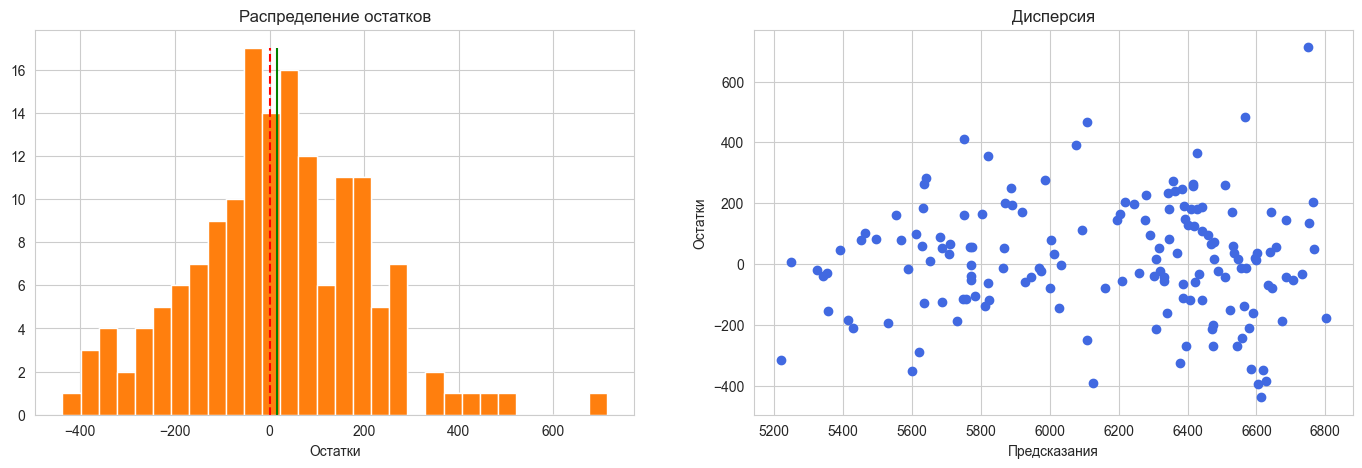

MAE: 146.16302
R2_score: 0.82475
95% доверительный интервал = (np.float64(6092.340075854289), np.float64(6221.375070058381))


In [201]:
cat_col_name = ['breed', 'pasture', 'father_breed', 'age', 'sugar_protein_ratio_cat', 'father_name']
num_col_name = ['feed_unit_squared', 'raw_protein']

X = ferma_main.drop(['id', 'milk_yield', 'fat_content', 'protein', 'feed_unit', 'sugar_protein_ratio'], axis=1)
y = ferma_main['milk_yield']

# Добавим значения ошибок в таблицу, чтобы позже сравнить значения
metrics_df.loc[2] = create_linear_model(X, y, num_col_name, cat_col_name)

In [202]:
metrics_df

,mse,rmse,mae,r2,residuals
0,43887.015010,209.492279,164.241945,0.784408,34.294516
1,37030.911311,192.434174,149.039652,0.818088,27.871259
2,35673.889886,188.875329,146.163024,0.824754,15.967703


При построении третий модели, у нас снова слегка улучшились показатели, однако модель все еще ошибается в `18%` случаев, а так же средняя абсолютная ошибка составляет `146` килограмм. 3-я модель показывает себя лучше всего, однако средняя ошибка у второй модели чуть меньше. Так же стоит отметить, что на гистограмме распределения остатков появились выбросы справа.

### Предсказание удоя

Нам нужно предсказать убой в таблице `cow_buy`. Для этого нам необходимо добавить недостающие столбцы в таблицу: `СПО`, `ЭКЕ`, `Сырой протеин`.
Лучше всего себя показала 3-я модель, проведем ту же подготовку, после чего обучим модель на таблице `ferma_main`

In [203]:
#Удаляем ненужный более столбец
ferma_main.drop(['id'], axis=1).head(1)

,milk_yield,feed_unit,raw_protein,sugar_protein_ratio,breed,pasture,father_breed,fat_content,protein,milk_taste,age,sugar_protein_ratio_cat,feed_unit_squared,father_name
0,5863,14.2,1743,0.89,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,буйный


In [204]:
# Добавляем новые столбцы
cow_buy['milk_yield'] = ferma_main['milk_yield'].mean() * 1.05
cow_buy['feed_unit'] = ferma_main['feed_unit'].mean() * 1.05
cow_buy['raw_protein'] = ferma_main['raw_protein'].mean() * 1.05
cow_buy['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean() * 1.05

# Проводим преобразования
cow_buy['feed_unit_squared'] = cow_buy['feed_unit'] ** 2
cow_buy['sugar_protein_ratio_cat'] = cow_buy['sugar_protein_ratio'].apply(lambda x: 1 if x > 0.92 else 0)

cow_buy.head()

,breed,pasture,father_breed,father_name,fat_content,protein,age,milk_yield,feed_unit,raw_protein,sugar_protein_ratio,feed_unit_squared,sugar_protein_ratio_cat
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1


In [205]:
# Смотрим на размерности таблиц
print(ferma_main.shape)
print(cow_buy.shape)

(628, 15)
(20, 13)


Посмотрим на столбцы в обоих датафреймах и передадим их в выборки

In [206]:
print(ferma_main.columns)
print(cow_buy.columns)

Index(['id', 'milk_yield', 'feed_unit', 'raw_protein', 'sugar_protein_ratio',
       'breed', 'pasture', 'father_breed', 'fat_content', 'protein',
       'milk_taste', 'age', 'sugar_protein_ratio_cat', 'feed_unit_squared',
       'father_name'],
      dtype='object')
Index(['breed', 'pasture', 'father_breed', 'father_name', 'fat_content',
       'protein', 'age', 'milk_yield', 'feed_unit', 'raw_protein',
       'sugar_protein_ratio', 'feed_unit_squared', 'sugar_protein_ratio_cat'],
      dtype='object')


In [207]:
# Передаем данные, необходимые для обучения модели
X_train_final = ferma_main[['breed', 'pasture', 'father_breed',
                            'father_name', 'age',
                            'raw_protein',
                            'feed_unit_squared',
                            'sugar_protein_ratio_cat']]
X_final = cow_buy[['breed', 'pasture', 'father_breed',
                   'father_name', 'age',
                   'raw_protein',
                   'feed_unit_squared',
                   'sugar_protein_ratio_cat']]

# Задаем целевой признак
y = ferma_main['milk_yield']

# Создаем список с категориальными и числовыми столбцами
num_col_name = ['feed_unit_squared', 'raw_protein']
cat_col_name = ['breed', 'pasture', 'father_breed', 'father_name', 'age', 'sugar_protein_ratio_cat']

# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final[num_col_name])
X_scaled = scaler.transform(X_final[num_col_name])

# Кодируем данные
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train_final[cat_col_name])
X_ohe = encoder.transform(X_final[cat_col_name])
encoder_col_names = encoder.get_feature_names_out()

# Собираем выборки
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_name)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_name)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

# Соединяем данные
X_train_final = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_final = pd.concat([X_scaled, X_ohe], axis=1)

# Обучаем и применяем модель
model_lr = LinearRegression()
model_lr.fit(X_train_final, y)
cow_buy['predicted_milk_yield'] = model_lr.predict(X_final)

cow_buy.head()

,breed,pasture,father_breed,father_name,fat_content,protein,age,milk_yield,feed_unit,raw_protein,sugar_protein_ratio,feed_unit_squared,sugar_protein_ratio_cat,predicted_milk_yield
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1,6583.691248
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1,6313.938111
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1,6301.240734
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1,6593.677429
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,6432.266561,15.276162,2019.947532,0.958744,233.361138,1,6545.136866


In [208]:
print(cow_buy['predicted_milk_yield'].min())
print(cow_buy['predicted_milk_yield'].max())

6098.151316152828
6593.677428541629


### Вывод:

Мы создали 3 модели, последняя из которых оказалась лучшей. Мы преобразовали столбец `СПО` в категориальный, и добавили столбец `ЭКЕ в квадрате`. Мы обучили модель на таблице`ferma_main`
 - R2_score составляет `0.82475`, что означает, что модель верно предсказывает значение в 82% случаев
 - MAE составляет `146.16302`, что означает, что модель в среднем ошибается на 146 кг в предсказании
 - Доверительный интервал варьируется от `6092 кг` до `6221 кг`
 - Распределение остатков немного сдвинуто вправо, что означает, что модель чаще предсказывает удой меньший, чем он есть на самом деле.

Для дальнейшего улучшения модели нам нужно больше характеристик, а так же больше данных для коров с удоем от 6250 до 6750

<br>
<br>

Минимальный предсказанный удой для коровы составляет `6098 кг`, максимальный же `6593 кг`

## Обучение модели логистической регрессии

1. Подготовим данные датасета `ferma_main.csv` и обучим на них модель `LogisticRegression`.
    - Используем в качестве целевого признак `Вкус молока`.
    - При необходимости преобразуем имеющиеся или добавим новые признаки.
    - Разобьем данные на тренировочную и тестовую выборки.
    - Кодируем категориальные признаки с помощью `OneHotEncoder`.
    - Масштабируем количественные признаки с помощью `StandardScaler`.
    - Обучим модель логистической регрессии на подготовленных данных.
    - Оценим качество модели на тестовой выборке: рассчитаем метрики accuracy, recall, precision.
    - Построим матрицу ошибок.
2. Проанализируем модель логистической регрессии.
    - Объясним, какая ошибка критичнее всего при покупке коров: первого или второго рода. Необходимо помнить, что главное для заказчика — вкусное молоко. Сформулируем ответ с учётом метрик recall и precision, выберите более важную из них.
    - Сведем критичную ошибку к нулю: для этого изменим порог принадлежности к классам. Ещё раз рассчитаем значения метрик recall и precision.
    - Оформим выводы: скажем, что нужно сделать дальше, исходя из анализа модели?
3. С помощью обученной модели спрогнозируем вкус молока коров, которых фермер хочет купить. Данные о них находятся в датасете `cow_buy.csv`.
    - Выполним подготовку данных, аналогичную той, которую делали для тренировочной выборки.
    - Получим прогноз вкуса молока коров.

In [209]:
ferma_main['milk_taste_cat'] = ferma_main['milk_taste'].apply(lambda x: 1 if x == 'вкусно' else 0)
ferma_main.columns

Index(['id', 'milk_yield', 'feed_unit', 'raw_protein', 'sugar_protein_ratio',
       'breed', 'pasture', 'father_breed', 'fat_content', 'protein',
       'milk_taste', 'age', 'sugar_protein_ratio_cat', 'feed_unit_squared',
       'father_name', 'milk_taste_cat'],
      dtype='object')

In [210]:
X = ferma_main[['raw_protein', 'breed',
                'pasture', 'father_breed', 'fat_content',
                'protein', 'age', 'sugar_protein_ratio_cat',
                'feed_unit_squared', 'father_name']]
y = ferma_main['milk_taste_cat']

num_col_name = ['raw_protein', 'fat_content', 'protein', 'feed_unit_squared']
cat_col_name = ['breed', 'pasture', 'father_breed', 'age', 'sugar_protein_ratio_cat', 'father_name']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)
# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_name])
X_test_scaled = scaler.transform(X_test[num_col_name])

# Кодируем данные
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_name])
X_test_ohe = encoder.transform(X_test[cat_col_name])
encoder_col_names = encoder.get_feature_names_out()

# Собираем выборки
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_name)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_name)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_test = pd.concat([X_test_scaled, X_test_ohe], axis=1)

# Создаем модель логистической регрессии
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# Рассчитываем метрики
print(f'Accuracy: {accuracy_score(y_test, predictions):.5f}')
print(f'Precision: {precision_score(y_test, predictions):.5f}')
print(f'Recall: {recall_score(y_test, predictions):.5f}')

Accuracy: 0.63057
Precision: 0.62295
Recall: 0.86364


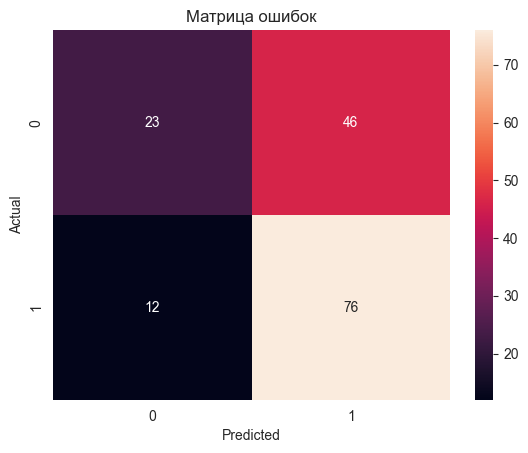

In [211]:
# Рисуем матрицу ошибок
sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок')
plt.show()

 - `Accuracy` составляет `0.631`, что означает, что модель верно предсказывает значение в 59% случаев
 - `Precision` составляет `0.622`, что означает, что из общего количества предсказаний 1-го класса, модель смогла верно предсказать 61%. То есть, она игнорирует ошибку второго рода
 - `Recall` составляет `0.863`, что означает, что модель смогла верно предсказать 1-й класс у 85% из общего числа данных 1-го класса. То есть она игнорирует ошибку первого рода

Так как для заказчика важным параметром является вкусное молоко, то нам нужно повысить характеристику `precision`. Нам неважно, сколько коров с потенциально вкусным молоком он не купит, нам важно, чтобы заказчик не купил корову с невкусным молоком. То есть, нам не важна `False Negative` надо повысить `True Positive` и снизить `False Positive`, а это метрика `precision`

In [212]:
y_proba = clf.predict_proba(X_test)[:, 1]

data = (pd.DataFrame(zip(y_test, y_proba), columns=['actual', 'y_probability'])
        .sort_values(by='y_probability', ascending=False))
data.head()

,actual,y_probability
85,1,0.861100
110,1,0.842725
66,1,0.841351
51,1,0.839460
8,1,0.817165


### Настройка модели

Посмотрим, как порог будет влиять на метрики модели.

In [213]:
thresholds = [round(i, 2) for i in np.linspace(0.5, 1, num=10, endpoint=False)]
columns = []

for i in thresholds:
    columns.append(f'threshold_{i}')
    data['threshold_' + str(i)] = data['y_probability'].apply(lambda x: 1 if x > i else 0)


def logistic_metrics(df, thresholds):
    output = pd.DataFrame(columns=['threshold', 'precision', 'total_true_objects',
                                   'predicted_true_objects', 'FP_count'])

    for threshold in thresholds:
        col = 'threshold_' + str(threshold)

        # Рассчитываем precision
        precision = df[df[col] == 1]['actual'].mean()

        # Считаем количество настоящих объектов класса 1
        total_true_objects = df['actual'].sum()

        # Считаем количество предсказанных объектов класса 1
        predicted_true_objects = df[col].sum()

        # Считаем количество False Positive предсказаний
        FP_count = df[(df['actual'] == 0) & (df[col] == 1)].shape[0]

        results = pd.DataFrame([{
            'threshold': threshold,
            'precision': precision,
            'total_true_objects': total_true_objects,
            'predicted_true_objects': predicted_true_objects,
            'FP_count': FP_count
        }])
        output = pd.concat([output, results])

    return output


metrics_df = logistic_metrics(data, thresholds)

In [214]:
metrics_df

,threshold,precision,total_true_objects,predicted_true_objects,FP_count
0,0.50,0.622951,88,122,46
0,0.55,0.654867,88,113,39
0,0.60,0.723404,88,94,26
0,0.65,0.769231,88,65,15
0,0.70,0.822222,88,45,8
0,0.75,0.884615,88,26,3
0,0.80,0.888889,88,9,1
0,0.85,1.000000,88,1,0
0,0.90,NaN,88,0,0
0,0.95,NaN,88,0,0



При пороге, равном `0.55` у нас слишком большое количество ошибок второго рода. Для порога `0.73` у нас слишком малое количество предсказанных объектов первого класса. Посмотрим на показатели для этого интервала

In [215]:
data = (pd.DataFrame(zip(y_test, y_proba), columns=['actual', 'y_probability'])
        .sort_values(by='y_probability', ascending=False))

thresholds = [round(i, 2) for i in np.linspace(0.55, 0.73, num=(73 - 55), endpoint=True)]
columns = []

for i in thresholds:
    columns.append(f'threshold_{i}')
    data['threshold_' + str(i)] = data['y_probability'].apply(lambda x: 1 if x > i else 0)

metrics_df = logistic_metrics(data, thresholds)
metrics_df

,threshold,precision,total_true_objects,predicted_true_objects,FP_count
0,0.55,0.654867,88,113,39
0,0.56,0.657658,88,111,38
0,0.57,0.666667,88,108,36
0,0.58,0.692308,88,104,32
0,0.59,0.700000,88,100,30
0,0.60,0.723404,88,94,26
0,0.61,0.750000,88,88,22
0,0.62,0.773810,88,84,19
0,0.63,0.770270,88,74,17
0,0.65,0.769231,88,65,15


При порогах `0.69`, `0.70`, `0.71` у нас лучшие показатели метрик. Для показателя `0.71` у нас слишком малое количество верно предсказанных объектов класса 1. При пороге `0.69` у нас слишком много объектов `False Positive`, возьмем порог `0.70`

In [216]:
threshold = 0.70

new_predictions = (y_proba > threshold).astype(int)

print(f'Accuracy: {accuracy_score(y_test, new_predictions):.5f}')
print(f'Precision: {precision_score(y_test, new_predictions):.5f}')
print(f'Recall: {recall_score(y_test, new_predictions):.5f}')

Accuracy: 0.62420
Precision: 0.82222
Recall: 0.42045


Старые метрики:
- Accuracy: 0.63057
- Precision: 0.62295
- Recall: 0.86364

Новые метрики:
- Accuracy: 0.62420
- Precision: 0.82222
- Recall: 0.42045

Мы видим, что значение `Accuracy` у нас изменилось совсем немного, однако значение `Precision` возросло, чего мы и добивались.

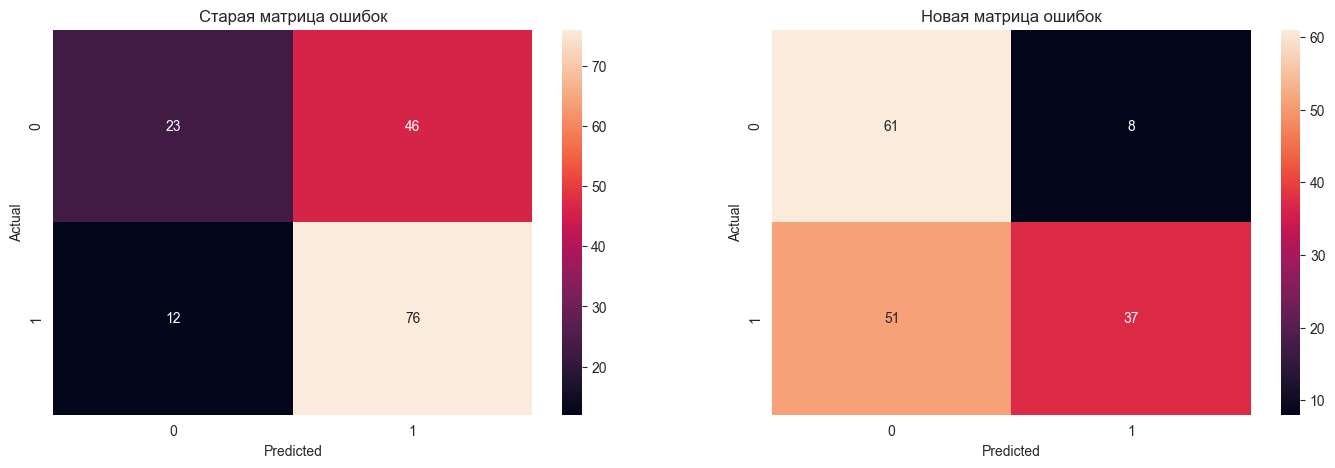

In [217]:
# Рисуем матрицу ошибок
plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Старая матрица ошибок')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, new_predictions), annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Новая матрица ошибок')

plt.show()

Нужная нам метрика `precision` выросла с `0.62` до `0.82`. Метрика `accuracy` же почти не изменилась. Мы снизили значение `False Positive` на 38

### Предсказание вкуса

Мы установили порог, ниже которого модель будет проставлять `не вкусно` для вкуса молока.

<br>

Выделим столбцы, по которым

In [218]:
X_train = ferma_main[['raw_protein', 'breed',
                      'pasture', 'father_breed', 'fat_content',
                      'protein', 'age', 'sugar_protein_ratio_cat',
                      'feed_unit_squared', 'father_name']]
y_train = ferma_main['milk_taste_cat']

X = cow_buy[['raw_protein', 'breed',
             'pasture', 'father_breed', 'fat_content',
             'protein', 'age', 'sugar_protein_ratio_cat',
             'feed_unit_squared', 'father_name']]

num_col_name = ['raw_protein', 'fat_content', 'protein', 'feed_unit_squared']
cat_col_name = ['breed', 'pasture', 'father_breed', 'age', 'sugar_protein_ratio_cat', 'father_name']

# Масштабируем данные
X_train_scaled = scaler.transform(X_train[num_col_name])
X_scaled = scaler.transform(X[num_col_name])

# Кодируем данные
X_train_ohe = encoder.transform(X_train[cat_col_name])
X_ohe = encoder.transform(X[cat_col_name])
encoder_col_names = encoder.get_feature_names_out()

# Собираем выборки
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_name)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_name)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)

X_train = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X = pd.concat([X_scaled, X_ohe], axis=1)

# Создаем модель
clf.fit(X_train, y_train)
predictions = clf.predict_proba(X)[:, 1]

# Предсказываем вкус молока
cow_buy['predicted_milk_taste'] = (predictions > threshold).astype(int)
cow_buy['predicted_milk_taste'] = cow_buy['predicted_milk_taste'].apply(
    lambda x: 'вкусно' if x == True else 'не вкусно')

cow_buy[['breed', 'father_breed', 'father_name', 'pasture',
         'fat_content', 'protein', 'age',
         'predicted_milk_yield', 'predicted_milk_taste']].sort_values(by='predicted_milk_taste', ascending=True)

,breed,father_breed,father_name,pasture,fat_content,protein,age,predicted_milk_yield,predicted_milk_taste
9,рефлешнсоверинг,айдиал,буйный,холмистое,3.40,3.079,менее_2_лет,6375.747238,вкусно
13,вис бик айдиал,соверин,барин,холмистое,3.42,3.075,менее_2_лет,6098.151316,вкусно
17,рефлешнсоверинг,соверин,геркулес,равнинное,3.77,3.053,менее_2_лет,6371.351509,не вкусно
16,вис бик айдиал,соверин,соловчик,холмистое,3.73,3.079,более_2_лет,6351.885016,не вкусно
15,рефлешнсоверинг,айдиал,буйный,холмистое,3.40,3.065,более_2_лет,6593.677429,не вкусно
14,рефлешнсоверинг,соверин,барин,равнинное,3.59,3.074,более_2_лет,6301.240734,не вкусно
12,вис бик айдиал,айдиал,геркулес,холмистое,3.68,3.046,более_2_лет,6583.691248,не вкусно
11,рефлешнсоверинг,соверин,геркулес,равнинное,3.73,3.073,более_2_лет,6589.281700,не вкусно
10,вис бик айдиал,соверин,соловчик,холмистое,3.73,3.055,более_2_лет,6351.885016,не вкусно
0,вис бик айдиал,айдиал,геркулес,холмистое,3.58,3.076,более_2_лет,6583.691248,не вкусно


### Вывод:

Так как для заказчика важным параметром является вкусное молоко, то нам нужно повысить характеристику `precision`. Нам неважно, сколько коров с потенциально вкусным молоком он не купит, нам важно, чтобы заказчик не купил корову с невкусным молоком. То есть, нам не важна `False Negative` надо повысить `True Positive` и снизить `False Positive`, а это метрика `precision`

<br>

Во время обучения модели логистической регрессии, мы подобрали порог, равный `0.70`. Если модель будет показывать, что объект получит класс 1 с вероятностью ниже пороговой, то мы присвоим ему класс 0. Таким образом, нужная нам метрика `precision` выросла с `0.62` до `0.82`. Метрика `accuracy` же почти не изменилась. Мы снизили значение `False Positive` на 38

<br>

С таким порогом, всего 2 коровы будут иметь нужный нам целевой признак

## Итоговые выводы:

Мы получили всего 2 коровы, подходящих под условия заказчика.



In [219]:
(cow_buy[['breed', 'father_breed', 'father_name', 'pasture',
          'fat_content', 'protein', 'age',
          'predicted_milk_yield', 'predicted_milk_taste']]
 .query('predicted_milk_taste == "вкусно" and predicted_milk_yield > 6000'))

,breed,father_breed,father_name,pasture,fat_content,protein,age,predicted_milk_yield,predicted_milk_taste
9,рефлешнсоверинг,айдиал,буйный,холмистое,3.40,3.079,менее_2_лет,6375.747238,вкусно
13,вис бик айдиал,соверин,барин,холмистое,3.42,3.075,менее_2_лет,6098.151316,вкусно


Во время исследовательского анализа числовых столбцов, мы увидели, что столбцы `Удой, кг` и `Белок, %` распределены нормально. Какой-то закономерности в остальных столбцах мы не наблюдаем.

<br>

В категориальных столбцах мы видим, что у фермера преобладает коровы со вкусным молоком. Так же 90% коров старше 2-х лет. Вкус молока не особо зависит от породы, пастбища, или же породы отца. Можно выделить, что слегка более вкусное молоко у породы `вис бик айдиал`. Так же стоит отметить, что у коров, которые паслись на `холмистом` пастбище, молоко сильно вкуснее

<br>
<br>

Во время корреляционного анализа между признаком `Удой` и другими числовыми признаками.
 - `Энергетическая кормовая единица`: корреляция положительная и ее коэффициент составляет `0.72`
 - `Сырой протеин, г`: корреляция положительна и ее коэффициент составляет `0.4`
 - `Сахаро-протеиновое соотношение`: корреляция положительна и ее коэффициент составляет `0.67`. Стоит отметить, что корреляция не является линейной, ибо мы видим 2 кластера. Мы можем наблюдать пропуск в диапазоне от `0.9` до `0.93`
 - `Жирность, %`: корреляция положительна и ее коэффициент составляет `0.68`. Идентично предыдущему признаку, мы можем наблюдать "пробел" в данных
 - `Белок, %`: корреляция положительна и ее коэффициент составляет `0.18`. Отметим, что корреляция совершенно нелинейна

Мы видим, что данные распределены равномерно. Можно отметить, что жирность у породы `вис бик айдиал` в среднем меньше, чем у `рефлешнсоверинг`. А так же процент белка `вис бик айдиал` в среднем больше, чем у `рефлешнсоверинг`

<br>

Можно отметить, что чем выше `удой` и `ЭКЕ`, тем вкуснее молоко. Чем больше `жирность`, тем вкуснее молоко

<br>

Мы можем видеть, что все показатели у коров старше 2-х лет выше. Это может быть вызвано еще и недостатком данных, ибо как мы видели ранее, количество коров младше 2-х лет составляет всего 10%.

<br>

Если абстрагироваться от разделения на признаки, то мы можем сказать, что для признака `Удой, кг` самая высокая корреляция с признаком `ЭКЕ`. Мы так же можем сказать, что для признака `Белок, %` связь с признаком `Удой, кг` свзяь отсутсвуют

<br>

Во время обучения модели линейной регрессии, мы создали 3 модели, последняя из которых оказалась лучшей. Мы преобразовали столбец `СПО` в категориальный, и добавили столбец `ЭКЕ в квадрате`. Мы обучили модель на таблице`ferma_main`
 - R2_score составляет `0.82475`, что означает, что модель верно предсказывает значение в 82% случаев
 - MAE составляет `146.16302`, что означает, что модель в среднем ошибается на 146 кг в предсказании
 - Доверительный интервал варьируется от `6092 кг` до `6221 кг`
 - Распределение остатков немного сдвинуто вправо, что означает, что модель чаще предсказывает удой меньший, чем он есть на самом деле.

Для дальнейшего улучшения модели нам нужно больше характеристик, а так же больше данных для коров с удоем от 6250 до 6750

<br>

Минимальный предсказанный удой для коровы составляет `6152 кг`, максимальный же `6682 кг`

<br>
<br>

Во время обучения модели логистической регрессии, мы подобрали порог, равный `0.70`. Если модель будет показывать, что объект получит класс 1 с вероятностью ниже пороговой, то мы присвоим ему класс 0. Таким образом, нужная нам метрика `precision` выросла с `0.62` до `0.82`. Метрика `accuracy` же почти не изменилась. Мы снизили значение `False Positive` на 38

<br>
<br>

Проделанная работа:
 - Мы импортировали данные в 3 разных датафрейма, привели имена столбцов к единому стилю, и кратко просмотрели информацию о каждом из них
 - Мы преобразовали следующие столбцы:
    - В датафрейме `cow_buy`
      - `current_fat_content` к типу `float`
      - `current_protein` к типу `float`
      - `age` к типу `bool`, где 1 — более 2-х лет, а 0 — менее 2 лет
    - В датафрейме `ferma_main`
      - `feed_unit` к типу `float`
      - `sugar_protein_ratio` к типу `float`
      - `fat_content` к типу `float`
      - `protein` к типу `float`
      - `milk_taste` к типу `bool`, где 1 — вкусно, а 2 — не вкусно
      - `age` к типу `bool`, где 1 — более 2-х лет, а 0 — менее 2 лет
- При обработке данных:
  - Мы создали список с названиями категориальных и числовых столбцов в датафреймах `ferma_main` и `cow_buy`
  - Мы избавились от неявных дубликатов в датафрейме `ferma_main`, а так же привели все значения к единому стилю, чтобы в дальнейшем не было проблем с созданием и применением модели.
- Мы удалили всего один выброс в столбце `milk_yield` который был вызван какой-то ошибкой или невнимательностью. В остальных же столбцах выбросы хоть и присутсвуют, но они не очень далеки от среднего значения. В столбце `fat_content` минимальное значение отличается от среднего всего на 0.6%. Эти выбросы мы оставили для того, чтобы модель обучалась более разнообразных данных
